In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
print(tf.__version__)
print(keras.__version__)
print(tf.test.is_gpu_available())
print(tf.test.is_built_with_cuda())

2.0.0
2.2.4-tf
True
True


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8097148231584432528
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6692228956
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6204737209808959801
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:81:00.0, compute capability: 6.1"
]


In [4]:
os.cpu_count()

NameError: name 'os' is not defined

In [15]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    print(e)

Memory growth must be set at program startup


In [15]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

Virtual devices must be set at program startup


In [5]:
import argparse
import locale
import os
import numpy as np
from numpy import dstack,vstack
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
import scipy.misc
import cv2
from tqdm import tqdm_notebook
from pandas import DataFrame
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
# import statsmodels.api as sm
# from matplotlib.mlab import bivariate_normal
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split

from keras.constraints import maxnorm
import keras
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import to_categorical
from tensorflow.keras import layers
from keras.models import Sequential, Model
from keras.layers import concatenate, Input, GlobalAveragePooling2D
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, Conv2D
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import SGD, Adam, RMSprop, Adagrad
from keras.utils import np_utils
from keras.layers.normalization import BatchNormalization
from keras import callbacks,  models
from keras import applications
from keras.applications import vgg16, vgg19, InceptionV3 ,ResNet152
from keras.models import load_model
from keras.utils import plot_model

%matplotlib inline
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from bayes_opt import BayesianOptimization
from sklearn.metrics import r2_score
import time
from vecstack import stacking
from sklearn.metrics import accuracy_score
from sklearn import neighbors, tree
from sklearn import metrics
from sklearn.metrics import f1_score, confusion_matrix, multilabel_confusion_matrix,cohen_kappa_score
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import winsound
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection._search import BaseSearchCV

Using TensorFlow backend.


In [9]:
cwd = os.getcwd()
#dir_name = 'image/classification/'
dir_name = 'text_folder/dataset_revised/classification_quantile_mix/'
path = cwd + '/' + dir_name # 경로 추적
print ("[%d] CATEGORIES ARE IN \n %s" % (len(os.listdir(path)), path))

categories = sorted(os.listdir(path)) # data 폴더 안에 있는 폴더 명
ncategories = len(categories)
print(categories)
valid_extscsv = [".csv"]
valid_extsimg = [".jpg", ".gif", ".png", ".jpeg"]
where = []
imgs = []
labels = []
labelscsv = []
dfs = []
num = 0

with tf.device("/cpu:0"):
    def imread(path):
        img = scipy.misc.imread(path).astype(np.float)
        if len(img.shape) == 2:
            img = np.transpose(np.array([img, img, img]), (2, 0, 1))
        return img

    for i, category in enumerate(categories):
        iter = 0
        for file in os.listdir(path + '/'+ category):
            if iter == 0:
                ext = os.path.splitext(file)[1]
                if ext.lower() not in valid_extscsv:
                    continue
                #fullpath = os.path.join(path + category, file)
                #here = os.path.join("/" + category, file)
                #where.append(here)
                df = pd.read_csv(dir_name + category+'/'+file,usecols=['Left Mean Pressure','Left Sum Pressure','Left Kurtosis'
                                                                       ,'Left Skewness','Left Area','Left Arch index','Left width','Left length'
                                                                       ,'Right Max Pressure','Right Mean Pressure','Right std','Right Sum Pressure','Right Kurtosis'
                                                                       ,'Right Skewness','Right Area','Right Arch index','Right width','Right length'])
                df = np.array(df)
                dfs.append(df)

                label_csv = i
                labelscsv.append(label_csv)

    # LOAD ALL IMAGES
    for i, category in enumerate(categories):
        iter = 0
        for file in os.listdir(path + '/'+ category):
            if iter == 0:
                ext = os.path.splitext(file)[1]
                if ext.lower() not in valid_extsimg:
                    continue
                #fullpath = os.path.join(path + category, file)
                #here = os.path.join("/" + category, file)
                #where.append(here)
                img = cv2.imread(dir_name + category+'/'+file,1) #왜 경로를 현재파일 이후로 지정해야 gray스케일이 나오는지는 알아봐야함
                #img = scipy.misc.imread(dir_name + category+'/'+file).astype(np.int32)
    #             img = cv2.resize(img, [32,32,3])
                img = cv2.resize(img,(32,32),interpolation = cv2.INTER_CUBIC)
                #img = img.astype('int32')
                img = img.astype('float32')
                img = img/ 127.5 - 1
                imgs.append(img) # NORMALIZE IMAGE a

                label_curr = i
                labels.append(label_curr)

    print ("Num imgs: %d" % (len(imgs)))
    print ("Num labels: %d" % (len(labels)))
    print (ncategories)
    print(imgs[12].shape)

[9] CATEGORIES ARE IN 
 C:\Users\user\processing/text_folder/dataset_revised/classification_quantile_mix/
['1', '2', '3', '4', '5', '6', '7', '8', '9']


ValueError: Usecols do not match columns, columns expected but not found: ['Right std', 'Right Skewness', 'Right Arch index', 'Left Kurtosis', 'Right Kurtosis', 'Left Skewness', 'Left Arch index']

# 새로운 데이터 테스트 용

In [6]:
%time sum(range(10000))
cwd = os.getcwd()
#dir_name = 'image/classification/'
dir_name = 'text_folder/dataset_revised/classification_sigma_allfeature_mix/'
path = cwd + '/' + dir_name # 경로 추적
print ("[%d] CATEGORIES ARE IN \n %s" % (len(os.listdir(path)), path))

categories = sorted(os.listdir(path)) # data 폴더 안에 있는 폴더 명
ncategories = len(categories)
print(categories)
valid_extscsv = [".csv"]
valid_extsimg = [".jpg", ".gif", ".png", ".jpeg"]
where = []
imgs = []
labels = []
labelscsv = []
dfs = []
num = 0

with tf.device("/cpu:0"):
    def imread(path):
        img = scipy.misc.imread(path).astype(np.float)
        if len(img.shape) == 2:
            img = np.transpose(np.array([img, img, img]), (2, 0, 1))
        return img

    for i, category in enumerate(categories):
        iter = 0
        for file in os.listdir(path + '/'+ category):
            if iter == 0:
                ext = os.path.splitext(file)[1]
                if ext.lower() not in valid_extscsv:
                    continue
                #fullpath = os.path.join(path + category, file)
                #here = os.path.join("/" + category, file)
                #where.append(here)
                df = pd.read_csv(dir_name + category+'/'+file,usecols=['Left Mean Pressure','Left Sum Pressure','Left Area','Left Rear Sum','Left Sub Area'
                                                                      ,'Right Mean Pressure','Right Sum Pressure','Right Area','Right Rear Sum','Right Sub Area'])
                df = np.array(df)
                dfs.append(df)

                label_csv = i
                labelscsv.append(label_csv)

    # LOAD ALL IMAGES
    for i, category in enumerate(categories):
        iter = 0
        for file in os.listdir(path + '/'+ category):
            if iter == 0:
                ext = os.path.splitext(file)[1]
                if ext.lower() not in valid_extsimg:
                    continue
                #fullpath = os.path.join(path + category, file)
                #here = os.path.join("/" + category, file)
                #where.append(here)
                img = cv2.imread(dir_name + category+'/'+file,1) #왜 경로를 현재파일 이후로 지정해야 gray스케일이 나오는지는 알아봐야함
                #img = scipy.misc.imread(dir_name + category+'/'+file).astype(np.int32)
    #             img = cv2.resize(img, [32,32,3])
                img = cv2.resize(img,(224,224),interpolation = cv2.INTER_CUBIC)
                #img = img.astype('int32')
                img = img.astype('float32')
                img = (img - np.mean(img))/np.std(img)
                imgs.append(img) # NORMALIZE IMAGE a

                label_curr = i
                labels.append(label_curr)

    print ("Num imgs: %d" % (len(imgs)))
    print ("Num labels: %d" % (len(labels)))
    print (ncategories)
    print(imgs[12].shape)

Wall time: 0 ns
[9] CATEGORIES ARE IN 
 C:\Users\user\processing/text_folder/dataset_revised/classification_sigma_allfeature_mix/
['1', '2', '3', '4', '5', '6', '7', '8', '9']
Num imgs: 36864
Num labels: 36864
9
(224, 224, 3)


# dfs 데이터 합치기(분류 1~9까지 합침)

In [7]:
dfs0 = pd.DataFrame(dfs[0])
dfs1 = pd.DataFrame(dfs[1])
dfs2 = pd.DataFrame(dfs[2])
dfs3 = pd.DataFrame(dfs[3])
dfs4 = pd.DataFrame(dfs[4])
dfs5 = pd.DataFrame(dfs[5])
dfs6 = pd.DataFrame(dfs[6])
dfs7 = pd.DataFrame(dfs[7])
dfs8 = pd.DataFrame(dfs[8])

dfa = pd.concat([dfs0,dfs1,dfs2,dfs3,dfs4,dfs5,dfs6,dfs7,dfs8])
dfa = dfa.reset_index(drop=True)
dfa.columns = ['Left Max Pressure','Left Mean Pressure','Left std','Left Sum Pressure','Left Kurtosis','Left Skewness','Left Area','Left Arch index','Left width','Left length','Right Max Pressure','Right Mean Pressure','Right std','Right Sum Pressure','Right Kurtosis','Right Skewness','Right Area','Right Arch index','Right width','Right length']

ValueError: Length mismatch: Expected axis has 10 elements, new values have 20 elements

# dfs 데이터 합치기(분류 1~9까지 합침) 데이터 확인 수정용

In [8]:
dfs0 = pd.DataFrame(dfs[0])
dfs1 = pd.DataFrame(dfs[1])
dfs2 = pd.DataFrame(dfs[2])
dfs3 = pd.DataFrame(dfs[3])
dfs4 = pd.DataFrame(dfs[4])
dfs5 = pd.DataFrame(dfs[5])
dfs6 = pd.DataFrame(dfs[6])
dfs7 = pd.DataFrame(dfs[7])
dfs8 = pd.DataFrame(dfs[8])

dfa = pd.concat([dfs0,dfs1,dfs2,dfs3,dfs4,dfs5,dfs6,dfs7,dfs8])
dfa = dfa.reset_index(drop=True)
dfa.columns = ['Left Mean Pressure','Left Sum Pressure','Left Area','Left Rear Sum','Left Sub Area'
                                                                      ,'Right Mean Pressure','Right Sum Pressure','Right Area','Right Rear Sum','Right Sub Area']

# 표준 정규화

In [9]:
# dfa['Left Max Pressure'] = (dfa['Left Max Pressure'] - dfa['Left Max Pressure'].mean()) / dfa['Left Max Pressure'].std()
dfa['Left Mean Pressure'] = (dfa['Left Mean Pressure'] - dfa['Left Mean Pressure'].mean()) / dfa['Left Mean Pressure'].std()
# dfa['Left Median Pressure'] = (dfa['Left Median Pressure'] - dfa['Left Median Pressure'].mean()) / dfa['Left Median Pressure'].std()
dfa['Left Sum Pressure'] = (dfa['Left Sum Pressure'] - dfa['Left Sum Pressure'].mean()) / dfa['Left Sum Pressure'].std()
dfa['Left Area'] = (dfa['Left Area'] - dfa['Left Area'].mean()) / dfa['Left Area'].std()
# dfa['Left Front Sum'] = (dfa['Left Front Sum'] - dfa['Left Front Sum'].mean()) / dfa['Left Front Sum'].std()
dfa['Left Rear Sum'] = (dfa['Left Rear Sum'] - dfa['Left Rear Sum'].mean()) / dfa['Left Rear Sum'].std()
# dfa['Left width'] = (dfa['Left width'] - dfa['Left width'].mean()) / dfa['Left width'].std()
# dfa['Left length'] = (dfa['Left length'] - dfa['Left length'].mean()) / dfa['Left length'].std()
dfa['Left Sub Area'] = (dfa['Left Sub Area'] - dfa['Left Sub Area'].mean()) / dfa['Left Sub Area'].std()

# dfa['Right Max Pressure'] = (dfa['Right Max Pressure'] - dfa['Right Max Pressure'].mean()) / dfa['Right Max Pressure'].std()
dfa['Right Mean Pressure'] = (dfa['Right Mean Pressure'] - dfa['Right Mean Pressure'].mean()) / dfa['Right Mean Pressure'].std()
# dfa['Right Median Pressure'] = (dfa['Right Median Pressure'] - dfa['Right Median Pressure'].mean()) / dfa['Right Median Pressure'].std()
dfa['Right Sum Pressure'] = (dfa['Right Sum Pressure'] - dfa['Right Sum Pressure'].mean()) / dfa['Right Sum Pressure'].std()
dfa['Right Area'] = (dfa['Right Area'] - dfa['Right Area'].mean()) / dfa['Right Area'].std()
# dfa['Right Front Sum'] = (dfa['Right Front Sum'] - dfa['Right Front Sum'].mean()) / dfa['Right Front Sum'].std()
dfa['Right Rear Sum'] = (dfa['Right Rear Sum'] - dfa['Right Rear Sum'].mean()) / dfa['Right Rear Sum'].std()
# dfa['Right width'] = (dfa['Right width'] - dfa['Right width'].mean()) / dfa['Right width'].std()
# dfa['Right length'] = (dfa['Right length'] - dfa['Right length'].mean()) / dfa['Right length'].std()
dfa['Right Sub Area'] = (dfa['Right Sub Area'] - dfa['Right Sub Area'].mean()) / dfa['Right Sub Area'].std()

In [45]:
dfa.describe()

,Left Mean Pressure,Left Sum Pressure,Left Area,Left Rear Sum,Left Sub Area,Right Mean Pressure,Right Sum Pressure,Right Area,Right Rear Sum,Right Sub Area
count,3.686400e+04,3.686400e+04,3.686400e+04,3.686400e+04,3.686400e+04,3.686400e+04,3.686400e+04,3.686400e+04,3.686400e+04,36864.000000
mean,-1.085551e-15,-3.777842e-16,-1.233581e-17,3.145632e-16,1.850372e-17,1.091719e-15,-3.947460e-16,-1.233581e-17,2.837237e-16,0.000000
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000
min,-2.636615e+00,-2.416751e+00,-1.966821e+00,-2.704826e+00,-2.457279e+00,-2.636615e+00,-2.416751e+00,-1.966821e+00,-2.704826e+00,-2.457279
25%,-7.275892e-01,-6.953634e-01,-6.905447e-01,-6.254113e-01,-6.036878e-01,-7.275892e-01,-6.953634e-01,-6.905447e-01,-6.254113e-01,-0.603688
50%,-5.130104e-02,6.971483e-02,-6.710233e-02,-4.382782e-02,4.111086e-02,-5.130104e-02,6.971483e-02,-6.710233e-02,-4.382782e-02,0.041111
75%,7.707382e-01,6.514208e-01,7.403507e-01,6.339041e-01,7.165539e-01,7.707382e-01,6.514208e-01,7.403507e-01,6.339041e-01,0.716554
max,2.792760e+00,2.863753e+00,3.525764e+00,2.744632e+00,2.579165e+00,2.792760e+00,2.863753e+00,3.525764e+00,2.744632e+00,2.579165


# 흑백 이미지 사용할 때

In [ ]:
plt.imshow(imgs[333])
gray_imgs = np.expand_dims(imgs,axis=3)
print(gray_imgs[1].shape)
plt.show()

# MLP 모델 입,출력 변수 선언 및 데이터 분할

In [10]:
with tf.device("/cpu:0"):
    from sklearn.preprocessing import OneHotEncoder
    X=np.array(imgs)
    y=np.array(labels)
    x = np.array(dfa.iloc[:,[0,1,3,5,6,8]])

    Y_class = np.array(y).reshape(-1,1)
    enc = OneHotEncoder()
    enc.fit(Y_class)
    Y_class_onehot = enc.transform(Y_class).toarray()
    Y_class_recovery = np.argmax(Y_class_onehot, axis=1)

    # NB_CLASSES = int(max(y)+1)
    # y_one_hot = np_utils.to_categorical(y, NB_CLASSES)

    X_train, X_test,x_train,x_test, Y_train, Y_test = train_test_split(X,x,Y_class_onehot,test_size=0.2,random_state=42)
#     X_train, X_test,Y_train, Y_test = train_test_split(np.array(X),Y_class_onehot,test_size=0.2,random_state=42)
    # xy = (X_train, X_test, Y_train, Y_test)
    # np.save("./img_data.npy", xy)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


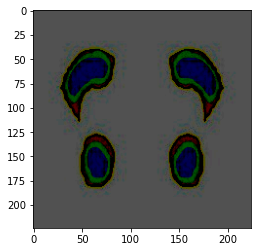

In [11]:
plt.imshow(imgs[0])

# MLP gridsearch

In [32]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
mlp = MLPClassifier(max_iter=100)
from sklearn.preprocessing import StandardScaler

start_time = time.time()

parameter_space = {
    'hidden_layer_sizes': [(40,20),(100),(100,200), (100,100), (200,200)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.001,0.01, 0.05],
    'learning_rate': ['constant','adaptive'],
}
clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=5)
clf.fit(x_train, Y_train)

# Best paramete set
print('Best parameters found:\n', clf.best_params_)

# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))


# 스케일링 : 표준화 ( 자료를 평균 0 , 분산 1이 되도록 전처리 ) 
# - 안정성, 수렴속도 향상, 정확도 향상등의 효과를 얻을 수 있다. [출처] [190617] 퍼셉트론/ MLP/ 하둡(Hadoop)|작성자 천프로

sc = StandardScaler() 
sc.fit(x_train)
sc.fit(x_test)
x_train_std = sc.transform(x_train)
x_test_std = sc.transform(x_test)

y_true, y_pred = Y_test , clf.predict(x_test)

from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))

print('run time :',round(time.time()-start_time,3))

KeyboardInterrupt: 

# Meta dataset

In [16]:
train_meta = pd.DataFrame(columns = ['MLP','CNN'])
test_meta = pd.DataFrame(columns = ['MLP','CNN'])

# MLP Layers

In [33]:
from sklearn.ensemble import BaggingClassifier

In [34]:
def mlp_model(dense1,dense2,dropout_rate):
    MLP = Sequential()
    MLP.add(Dense(18, input_dim=18, activation="relu", kernel_initializer="he_normal"))
    MLP.add(Dense(dense1, activation="relu", kernel_initializer="he_normal"))
    MLP.add(Dense(dense2, activation="relu", kernel_initializer="he_normal"))
    MLP.add(Dropout(dropout_rate))
    MLP.add(BatchNormalization())
    MLP.add(Dense(9, activation="softmax", kernel_initializer="he_normal"))
    # Compile model
    MLP.compile(loss='categorical_crossentropy', optimizer= Adam(lr=0.002), metrics=['accuracy'])
#     MLP.summary()
    ## Fit the model
    return MLP

In [35]:
MLP_search_point = {'dense1': (1,9,1),
                    'dense2':(1,9,1),
                    'dropout_rate':(0.1,0.5)}

skfolds=StratifiedKFold(n_splits=5, random_state=42,shuffle =True)

Y_train_recovery = np.argmax(Y_train, axis=1)
gp_params = {"alpha":1e-10}

def MLP_opt(dense1,dense2,dropout_rate):
    start_time = time.time()
    cvscores = []
    
    for train_index, val_index in skfolds.split(x, Y_class_recovery):
        model = mlp_model(int(dense1),int(dense2),float(dropout_rate))
#         X_skftrain, X_val = X[train_index],X[val_index]       
        x_skftrain, x_val = x[train_index],x[val_index]
        Y_skftrain, Y_val = Y_class_onehot[train_index],Y_class_onehot[val_index]

        model.fit(x_skftrain,Y_skftrain, batch_size=2000, epochs=200,verbose=0)
#         score = cnn.evaluate(X_val,Y_val,verbose=0)
#         cvscores.append(score[1]*100)
        
        f1scores = f1_score(np.argmax(Y_val,axis=1),np.argmax(model.predict(x_val),axis=1),average = 'weighted',labels=np.unique(np.argmax(model.predict(x_val),axis=1)))
        
        cvscores.append(f1scores*100)
    
    print('time',round(time.time()-start_time,3)/60)

    return np.mean(cvscores)


# if __name__ == "__main__":
result = BayesianOptimization(MLP_opt, MLP_search_point,    random_state=10,    verbose=2) 
result.maximize(acq='ucb',n_iter=10, kappa=3, init_points=3 , **gp_params)
#     for i, res in enumerate(result.res):
#         print('Iteration {}: \n\t{}'.format(i, res))
#         print('Final result: ', result.max)

frequency = 2500  # Set Frequency To 2500 Hertz
duration = 5000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration) #cell 결과내고 확인 할 때 beep 소리 내는 기능

ValueError: setting an array element with a sequence.

# k opt

In [108]:
MLP_search_point = {'k': (1,1000)}
                   

skfolds=StratifiedKFold(n_splits=5, random_state=42,shuffle =True)

Y_train_recovery = np.argmax(Y_train, axis=1)
gp_params = {"alpha":1e-10}
time_all = []
scores_all = []
k_all = []
def MLP_opt(k):
    start_time = time.time()
    cvscores = []
    
    for train_index, val_index in skfolds.split(x, Y_class_recovery):
        model = KNeighborsClassifier(n_neighbors = int(k),weights = 'uniform') # KNN
#         model = tree.DecisionTreeClassifier(max_depth=k, min_samples_leaf=250, min_samples_split=9) #CART
#         X_skftrain, X_val = X[train_index],X[val_index]       
        x_skftrain, x_val = x[train_index],x[val_index]
        Y_skftrain, Y_val = Y_class_onehot[train_index],Y_class_onehot[val_index]

        model = model.fit(x_skftrain,Y_skftrain)
        
        f1scores = f1_score(np.argmax(Y_val,axis=1),np.argmax(model.predict(x_val),axis=1),average = 'weighted',labels=np.unique(np.argmax(model.predict(x_val),axis=1)))
        
        cvscores.append(f1scores)
    
    print('time',round(time.time()-start_time,3)/60)

    time_all.append(round(time.time()-start_time,3)/60)
    scores_all.append(np.mean(cvscores))
    k_all.append(int(k))
    return np.mean(cvscores)


# if __name__ == "__main__":
result = BayesianOptimization(MLP_opt, MLP_search_point,    random_state=10,    verbose=2) 
result.maximize(acq='ucb',n_iter=10, kappa=2.576, init_points=5 , **gp_params)
#     for i, res in enumerate(result.res):
#         print('Iteration {}: \n\t{}'.format(i, res))
#         print('Final result: ', result.max)

frequency = 2500  # Set Frequency To 2500 Hertz
duration = 5000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration) #cell 결과내고 확인 할 때 beep 소리 내는 기능

|   iter    |  target   |     k     |
-------------------------------------
time 1.0643333333333334
|  1        |  0.4959   |  771.5    |
time 0.39766666666666667
|  2        |  0.6449   |  21.73    |
time 0.9027499999999999
|  3        |  0.5054   |  634.0    |
time 0.9744333333333334
|  4        |  0.4972   |  749.1    |
time 0.7916500000000001
|  5        |  0.5191   |  499.0    |
time 0.3345166666666667
|  6        |  0.6658   |  1.282    |
time 0.3340666666666667
|  7        |  0.6658   |  1.069    |
time 1.12815
|  8        |  0.4812   |  1e+03    |
time 0.6459499999999999
|  9        |  0.4435   |  308.0    |
time 1.06585
|  10       |  0.4877   |  907.4    |
time 0.7141333333333333
|  11       |  0.4519   |  403.0    |
time 0.33485000000000004
|  12       |  0.6658   |  1.004    |
time 0.3577666666666667
|  13       |  0.659    |  6.477    |
time 0.5333333333333333
|  14       |  0.5115   |  168.1    |
time 0.47100000000000003
|  15       |  0.5625   |  102.0    |


In [38]:
scores_all

[75.47573845422495,
 86.72146946131203,
 62.18991489321561,
 73.9502316658316,
 63.04225532656253,
 90.32613940070105,
 90.32613940070105,
 90.32613940070105,
 90.88073939858836,
 89.18270254928106,
 90.88073939858836,
 90.88073939858836,
 89.18922750254521,
 90.88073939858836,
 90.88073939858836]

In [61]:
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
# Define Kernel Function
kernel = kernels.Matern()

# Define Model
model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20, alpha=0.1, normalize_y=False)
model.fit(np.array(k_all).reshape(-1, 1), np.array(scores_all).reshape(-1,1))
params = model.get_params()

mu_s, std_s = model.predict(X, return_std=True)


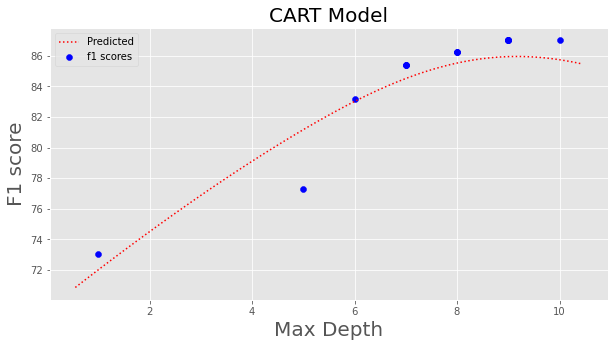

In [90]:
from scipy import stats
from scipy.stats import norm

from sklearn.gaussian_process import GaussianProcessRegressor, kernels
# Define Kernel Function
kernel = kernels.Matern()

# Define Model
model = GaussianProcessRegressor(kernel=kernel, alpha=0.1, normalize_y=False)
# model.fit(np.array(k_all).reshape(-1, 1), np.array(time_all).reshape(-1,1))
model.fit(np.array(k_all).reshape(-1, 1), np.array(scores_all).reshape(-1,1))
params = model.get_params()


plt.figure(figsize = (10,5) )
plt.style.use('ggplot')

# plt.scatter(k_all,time_all,color='green', marker='o')
plt.scatter(k_all,scores_all,color = 'b',marker='o')
xmin, xmax = plt.xlim()
X = np.linspace(xmin, xmax, 100)
X = np.atleast_2d(X).T
mu_s, std_s = model.predict(X, return_std=True)

plt.plot(X, mu_s, label='Predicted', color ='r',linestyle=':')

# plt.legend(labels=['Predicted','Time[min]'])
plt.legend(labels=['Predicted','f1 scores'])

plt.title('CART Model',{'fontsize' : 20})

# plt.ylabel('Computation Time[min]',{'fontsize' : 20})
plt.ylabel('F1 score',{'fontsize' : 20})

plt.xlabel('Max Depth',{'fontsize' : 20})
plt.show()

In [13]:
bag_MLP = BaggingClassifier(mlp_model(),n_estimators=100,max_samples=10000,bootstrap=True, n_jobs=-1, random_state=42)

# image generator

In [13]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        fill_mode= 'nearest')

val_datagen = ImageDataGenerator()

In [14]:
train_generator = train_datagen.flow(X_train,Y_train,batch_size=100)
val_generator = val_datagen.flow(X_test,Y_test,batch_size=25)

# VGG16 Model

In [9]:
from keras.applications import vgg16, InceptionV3 ,ResNet152
from keras import models

vgg_conv = vgg16.VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(32, 32, 3)
                )

for layer in vgg_conv.layers:
    layer.trainable = False

# for layer in vgg_conv.layers[:-4]:
#     layer.trainable = False

# Check the trainable status of the individual layers
# for layer in vgg_conv.layers:
#     print(layer, layer.trainable)
    
 
 
# Add new layers
model = Sequential() 
model.add(vgg_conv) 
model.add(Flatten()) 
model.add(Dense(512, activation='relu', name='Dense_Intermediate')) 
model.add(BatchNormalization())
model.add(Dropout(0.5, name='Dropout_Regularization')) 
model.add(Dense(9, activation='softmax', name='Output'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
Dense_Intermediate (Dense)   (None, 512)               262656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
Dropout_Regularization (Drop (None, 512)               0         
_________________________________________________________________
Output (Dense)               (None, 9)                 4617      
Total params: 14,984,009
Trainable params: 268,297
Non-trainable params: 14,715,712
____________________________________

In [15]:

# Train the model
history = model.fit(
      X_train,Y_train,
      epochs=10,
      validation_data=(X_test,Y_test),
      verbose=1)
 
# Save the model
model.save('small_last4.h5')

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

Train on 29491 samples, validate on 7373 samples
Epoch 1/10


KeyboardInterrupt: 

In [11]:
def vgg16_model(learning_rate,dense_node,dropout_rate):
    
    vgg_conv = vgg16.VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(224, 224, 3)
                )

    for layer in vgg_conv.layers:
        layer.trainable = False

    # for layer in vgg_conv.layers[:-4]:
    #     layer.trainable = False

    # Check the trainable status of the individual layers
    # for layer in vgg_conv.layers:
    #     print(layer, layer.trainable)



    # Add new layers
    model = Sequential() 
    model.add(vgg_conv) 
    model.add(Flatten()) 
    model.add(Dropout(0.5, name='Dropout_Regularization')) 
    model.add(Dense(81, activation='relu', name='Dense_Intermediate')) 
    model.add(BatchNormalization())
    model.add(Dense(9, activation='softmax', name='Output'))

    # Show a summary of the model. Check the number of trainable parameters
    # Compile the model
    model.compile(optimizer=Adam(lr=1e-5,epsilon=1e-07), loss='categorical_crossentropy', metrics=['accuracy'] )

#     model.summary()
    return model

In [12]:
pd.set_option('display.max_rows',1000)

In [14]:
input_tensor = Input(shape=(224,224, 3))  # this assumes K.image_data_format() == 'channels_last'
prior = applications.vgg16.VGG16( input_tensor=input_tensor,weights='imagenet',include_top=False, classes = 9)  

for cnn_block_layer in prior.layers[:-3]: 
    cnn_block_layer.trainable = False 

layers = [(layer, layer.name, layer.trainable) for layer in prior.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at...,input_2,False
1,<keras.layers.convolutional.Conv2D object at 0...,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0...,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0...,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0...,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0...,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0...,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0...,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0...,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0...,block3_conv3,False


In [13]:
def InceptionV3(learning_rate,dense_node,dropout_rate):
    input_tensor = Input(shape=(224,224, 3))  # this assumes K.image_data_format() == 'channels_last'
    prior = applications.vgg19.VGG19( input_tensor=input_tensor,weights='imagenet',include_top=False, classes = 9)  
    
    for cnn_block_layer in prior.layers[:-4]:
        cnn_block_layer.trainable = False 
        
    CNN_model = Sequential() 
    CNN_model.add(prior) 
    CNN_model.add(Flatten())
    CNN_model.add(Dropout(0.5, name='Dropout_Regularization')) 
    CNN_model.add(Dense(81, activation='relu', name='Dense_Intermediate')) 
    CNN_model.add(BatchNormalization())
    CNN_model.add(Dense(9, activation='softmax', name='Output'))

#     for cnn_block_layer in CNN_model.layers[0].layers: 
#         cnn_block_layer.trainable = False 
#     CNN_model.layers[0].trainable = False 

#     CNN_model.compile(optimizer=RMSprop(lr=1e-6), loss='categorical_crossentropy', metrics=['accuracy'] )
    CNN_model.compile(optimizer=RMSprop(lr=1e-6,epsilon=1e-07), loss='categorical_crossentropy', metrics=['accuracy'] )
#     CNN_model.summary()
    return CNN_model

In [14]:
def ResNet152(learning_rate,dense_node,dropout_rate):
    input_tensor = Input(shape=(224, 224, 3))  # K.image_data_format() == 'channels_last'라고 가정합니다
    prior = applications.resnet50.ResNet50( input_tensor=input_tensor,weights='imagenet',include_top=False, classes = 9)  
    
    for cnn_block_layer in prior.layers:
        cnn_block_layer.trainable = False 
        
    CNN_model = Sequential() 
    CNN_model.add(prior) 
    CNN_model.add(Flatten())
    CNN_model.add(Dense(1024, activation='relu', name='Dense_Intermediate')) 
    CNN_model.add(BatchNormalization())
    CNN_model.add(Dense(1024, activation='relu', name='Dense_Intermediate2')) 
    CNN_model.add(Dropout(0.7, name='Dropout_Regularization')) 
    CNN_model.add(Dense(9, activation='softmax', name='Output'))

#     for cnn_block_layer in CNN_model.layers[0].layers: 
#         cnn_block_layer.trainable = False 
#     CNN_model.layers[0].trainable = False 

    CNN_model.compile(optimizer=Adam(lr=1e-6,epsilon=1e-07), loss='categorical_crossentropy', metrics=['accuracy'] )
#     CNN_model.summary()
    return CNN_model

In [15]:
from keras.preprocessing.image import ImageDataGenerator

generator = ImageDataGenerator(rotation_range = 0, zca_whitening=True, shear_range=0.05,
    zoom_range=0.05,width_shift_range=0.05, height_shift_range=0.05)

data_flow = generator.flow(X_train,Y_train, batch_size = 50)
data_valflow = generator.flow(X_test,Y_test, batch_size = 50)

C:\Users\user\.conda\envs\cuda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:336: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [16]:
RES = InceptionV3(0.08492 ,18,0.3161)
RES_history =[]

# RES_history.append(RES.fit(X_train, Y_train ,epochs=10, batch_size=100, validation_data=(X_test, Y_test),verbose=2))

# skfolds=StratifiedKFold(n_splits=2, random_state=42,shuffle =True)
# Y_train_recovery = np.argmax(Y_train, axis=1)

# for train_index, val_index in skfolds.split(x, Y_class_recovery):
#         cnn = ResNet152(float(0.08492),int(18),float(0.3161))
#         X_skftrain, X_val = X[train_index],X[val_index]
#         Y_skftrain, Y_val = Y_class_onehot[train_index],Y_class_onehot[val_index]

#         RES_history.append(cnn.fit_generator(data_flow, epochs=25, steps_per_epoch=300,
#                           verbose=2, validation_data=data_valflow,validation_steps = 2000))
        
RES_history.append(RES.fit_generator(data_flow, epochs=20,steps_per_epoch = 100,
                           verbose=2, validation_data=data_valflow,validation_steps = 100))
f1scores = f1_score(np.argmax(Y_test,axis=1),np.argmax(RES.predict(X_test),axis=1),average = 'weighted',labels=np.unique(np.argmax(RES.predict(X_test),axis=1)))

Epoch 1/20


C:\Users\user\.conda\envs\cuda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\user\.conda\envs\cuda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


KeyboardInterrupt: 

In [22]:
print(f1scores)

0.5034731956765754


In [23]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc=0)

def plot_acc(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc=0)
    
def main():
    batch_size = 100
    epochs = 10
 
    model = ResNet152(1,1,1)
    

    history = model.fit_generator(data_flow, epochs=epochs, steps_per_epoch=10,
                                  verbose=2, validation_data=(X_test, Y_test))
 
    performance_test = model.evaluate(X_test, Y_test, batch_size=100,
        verbose=0)
    print('\nTest Result ->', performance_test)
 
    plot_acc(history)
    plt.show()
    plot_loss(history)
    plt.show()
    
    
if __name__ == '__main__':
    main()

Epoch 1/10
 - 32s - loss: 3.1057 - accuracy: 0.2985 - val_loss: 1.8423 - val_accuracy: 0.4720
Epoch 2/10
 - 12s - loss: 2.2787 - accuracy: 0.4200 - val_loss: 1.9671 - val_accuracy: 0.4469
Epoch 3/10
 - 12s - loss: 1.9834 - accuracy: 0.4490 - val_loss: 1.9616 - val_accuracy: 0.4721
Epoch 4/10
 - 12s - loss: 1.7817 - accuracy: 0.4915 - val_loss: 1.9801 - val_accuracy: 0.3936
Epoch 5/10
 - 12s - loss: 1.6732 - accuracy: 0.4790 - val_loss: 1.9279 - val_accuracy: 0.4723
Epoch 6/10
 - 12s - loss: 1.6473 - accuracy: 0.4845 - val_loss: 1.9228 - val_accuracy: 0.4694
Epoch 7/10
 - 12s - loss: 1.5565 - accuracy: 0.4805 - val_loss: 1.9303 - val_accuracy: 0.4625
Epoch 8/10
 - 12s - loss: 1.4581 - accuracy: 0.5115 - val_loss: 1.8951 - val_accuracy: 0.4672
Epoch 9/10
 - 12s - loss: 1.4017 - accuracy: 0.5315 - val_loss: 1.8749 - val_accuracy: 0.4594
Epoch 10/10
 - 12s - loss: 1.3264 - accuracy: 0.5620 - val_loss: 1.8720 - val_accuracy: 0.4682


NameError: name 'data' is not defined

In [ ]:
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adam, SGD, RMSprop, Nadam, Adamax, Adagrad, Adadelta
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers.normalization import BatchNormalization



CNN_search_point = {'learning_rate': (0.0001,0.1),
                  'dense_node':(1,1024),
                  'dropout_rate':(0.01,0.50)}

skfolds=StratifiedKFold(n_splits=5, random_state=42,shuffle =True)

Y_train_recovery = np.argmax(Y_train, axis=1)

def CNN_opt(learning_rate,dense_node,dropout_rate):
    start_time = time.time()
    cvscores = []
    
    for train_index, val_index in skfolds.split(x, Y_class_recovery):
        cnn = ResNet152(float(learning_rate),int(dense_node),float(dropout_rate))
        X_skftrain, X_val = X[train_index],X[val_index]
        Y_skftrain, Y_val = Y_class_onehot[train_index],Y_class_onehot[val_index]

        cnn.fit(X_skftrain,Y_skftrain,batch_size=1000, epochs=50,verbose=0)
#         score = cnn.evaluate(X_val,Y_val,verbose=0)
#         cvscores.append(score[1]*100)
        
        f1scores = f1_score(np.argmax(Y_val,axis=1),np.argmax(cnn.predict(X_val),axis=1),average = 'weighted',labels=np.unique(np.argmax(cnn.predict(X_val),axis=1)))
        
        cvscores.append(f1scores*100)
    
    print('time',round(time.time()-start_time,3)/60)

    return np.mean(cvscores)


if __name__ == "__main__":
    result = BayesianOptimization(CNN_opt, CNN_search_point,    random_state=10,    verbose=2) 
    result.maximize(acq='ucb',n_iter=3)
    for i, res in enumerate(result.res):
        print('Iteration {}: \n\t{}'.format(i, res))
        print('Final result: ', result.max)

frequency = 2500  # Set Frequency To 2500 Hertz
duration = 5000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration) #cell 결과내고 확인 할 때 beep 소리 내는 기능

|   iter    |  target   | dense_... | dropou... | learni... |
-------------------------------------------------------------
time 45.47138333333333
|  1        |  29.19    |  790.1    |  0.02017  |  0.0634   |
time 45.6431
|  2        |  22.6     |  767.0    |  0.2543   |  0.02256  |
time 46.25438333333333
|  3        |  30.14    |  203.6    |  0.3827   |  0.01699  |
time 46.97048333333333
|  4        |  41.8     |  91.37    |  0.3458   |  0.09534  |


# k - opt

1001
tr 1.0 te 0.4085423728813559
0.32165731577260304
tr 1.0 te 0.40330892324382966
0.3132751034111432
tr 1.0 te 0.40586001085187196
0.3235265347007289
tr 1.0 te 0.41616928920238744
0.3500316676076196
tr 1.0 te 0.4056437389770723
0.3210865902272635
KNN run time : 9.608849999999999
0.6994505064626211
3001
tr 1.0 te 0.3726101694915254
0.21966450222058687
tr 1.0 te 0.3677786818551668
0.21293301335559267
tr 1.0 te 0.37344004340748777
0.22273959751507322
tr 1.0 te 0.38334237655995657
0.24520172607333857
tr 1.0 te 0.36928503595170264
0.21590797723589839
KNN run time : 18.515333333333334
0.6466222176859397


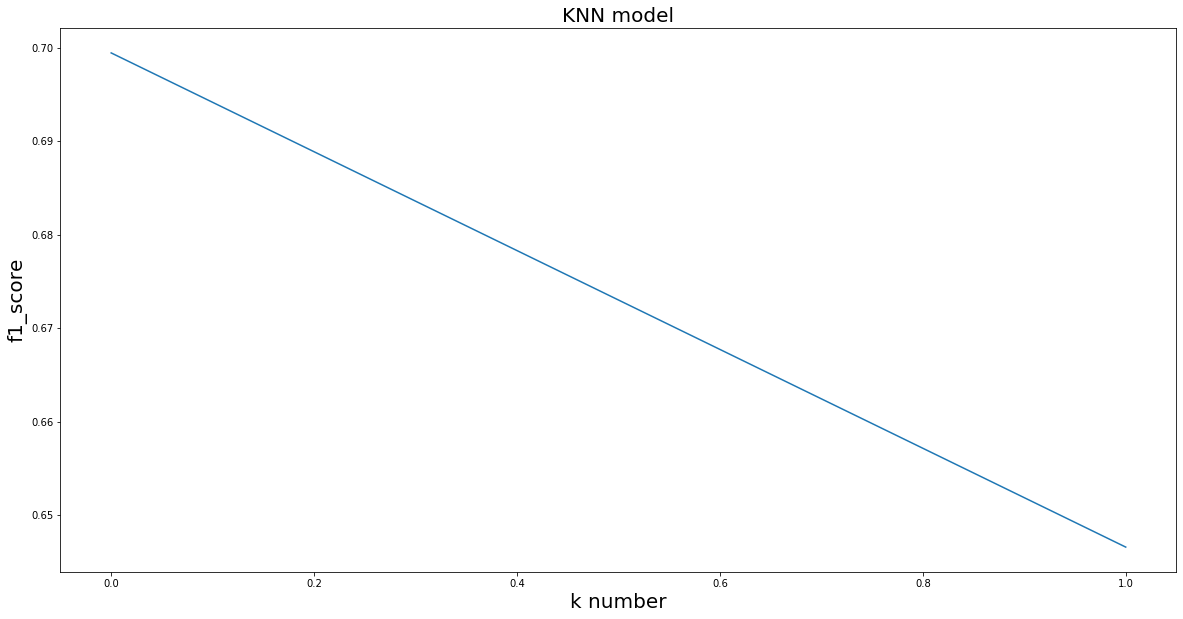

In [21]:
seed = 7
np.random.seed(seed)

skfolds=StratifiedKFold(n_splits=2, random_state=42,shuffle =True)
kfolds = KFold(5,shuffle=True)

KNN_history = []
KNN_cvscores = []
KNN_time = []
for k in range(1001,10000,2000):
    start_time = time.time()
    print(k)
    small_scores = []
    for train_index, val_index in skfolds.split(x, Y_class_recovery):
#         print('%d'%k[i],'train data:', len(train_index), 'validation data:', len(val_index))
        x_skftrain, x_val = x[train_index],x[val_index]
#         X_skftrain, X_val = X[train_index],X[val_index]
        Y_skftrain, Y_val = Y_class_onehot[train_index],Y_class_onehot[val_index]

        KNN = KNeighborsClassifier(n_neighbors=k, weights = 'distance',leaf_size=500)
        modelknn = KNN.fit(x_skftrain, Y_skftrain)
        scorestr = modelknn.score(x_skftrain,Y_skftrain)
        scores = modelknn.score(x_val,Y_val)
        f1scores = f1_score(np.argmax(Y_val,axis=1),np.argmax(modelknn.predict(x_val),axis=1),average = 'weighted',labels=np.unique(np.argmax(modelknn.predict(x_val),axis=1)))
        kappa_score = cohen_kappa_score(np.argmax(Y_val,axis=1),np.argmax(modelknn.predict(x_val),axis=1),labels=np.unique(np.argmax(modelknn.predict(x_val),axis=1)))
        
        print('tr',scorestr,'te',scores)
        print(kappa_score)
        small_scores.append(f1scores)

    knntime = time.time()
    print('KNN run time :',round(knntime-start_time,3)/60)
    print(np.mean(small_scores))
    
    KNN_cvscores.append(np.mean(small_scores))
    KNN_time.append(round(knntime-start_time,3)/60)

plt.figure(figsize=(20,10))
plt.plot(KNN_cvscores)
plt.title('KNN model',{'fontsize' : 20})
plt.ylabel('f1_score',{'fontsize' : 20})
plt.xlabel('k number',{'fontsize' : 20})
plt.show()


frequency = 2500  # Set Frequency To 2500 Hertz
duration = 5000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration) #cell 결과내고 확인 할 때 beep 소리 내는 기능

# max_depth - opt

In [82]:
seed = 7
np.random.seed(seed)

skfolds=StratifiedKFold(n_splits=5, random_state=42,shuffle =True)
kfolds = KFold(5,shuffle=True)

CART_history = []
CART_cvscores = []
CART_time = []
for k in range(1,30):
    start_time = time.time()
    print(k)
    small_scores = []
    for train_index, val_index in skfolds.split(x, Y_class_recovery):
#         print('%d'%k[i],'train data:', len(train_index), 'validation data:', len(val_index))
        x_skftrain, x_val = x[train_index],x[val_index]
#         X_skftrain, X_val = X[train_index],X[val_index]
        Y_skftrain, Y_val = Y_class_onehot[train_index],Y_class_onehot[val_index]

        CART = tree.DecisionTreeClassifier(max_depth=k,min_samples_leaf=250,min_samples_split=9)
        modelCART = CART.fit(x_skftrain, Y_skftrain)
        
        scores = modelCART.score(x_val,Y_val)
        scorestr = modelCART.score(x_skftrain,Y_skftrain)

        
        f1scores = f1_score(np.argmax(Y_val,axis=1),np.argmax(modelCART.predict(x_val),axis=1),average = 'weighted',labels=np.unique(np.argmax(modelCART.predict(x_val),axis=1)))
        
        kappa_score = cohen_kappa_score(np.argmax(Y_val,axis=1),np.argmax(modelCART.predict(x_val),axis=1),labels=np.unique(np.argmax(modelCART.predict(x_val),axis=1)))
        print('tr',scorestr,'te',scores)
        print(kappa_score)
        small_scores.append(f1scores)

    carttime = time.time()
    print('CART run time :',round(carttime-start_time,3)/60)
    print(np.mean(small_scores))
    
    CART_cvscores.append(np.mean(small_scores))
    CART_time.append(round(carttime-start_time,3)/60)

plt.figure(figsize=(10,5))
plt.plot(CART_cvscores,color='green', marker='o', linestyle='dashed')
plt.title('CART model',{'fontsize' : 20})
plt.ylabel('f1_score',{'fontsize' : 20})
plt.xlabel('max depth',{'fontsize' : 20})
plt.show()

1


ValueError: Found input variables with inconsistent numbers of samples: [100, 36864]

In [12]:
CNN_search_point = {'learning_rate': (0.001,0.1),
                  'dense_node':(1,1024),
                  'dropout_rate':(0.1,0.5)}

skfolds=StratifiedKFold(n_splits=5, random_state=42,shuffle =True)

Y_train_recovery = np.argmax(Y_train, axis=1)

mlp_opt = MLPClassifier()

def CNN_opt(learning_rate,dense_node,dropout_rate):
    start_time = time.time()
    cvscores = []
    
    for train_index, val_index in skfolds.split(x, Y_class_recovery):
        cnn = vgg16_model(float(learning_rate),int(dense_node),float(dropout_rate))
        X_skftrain, X_val = X[train_index],X[val_index]       
        x_skftrain, x_val = x[train_index],x[val_index]
        Y_skftrain, Y_val = Y_class_onehot[train_index],Y_class_onehot[val_index]

        cnn.fit(X_skftrain,Y_skftrain,batch_size=2000, epochs=2,verbose=0)
#         score = cnn.evaluate(X_val,Y_val,verbose=0)
#         cvscores.append(score[1]*100)
        
        f1scores = f1_score(np.argmax(Y_val,axis=1),np.argmax(cnn.predict(X_val),axis=1),average = 'weighted',labels=np.unique(np.argmax(cnn.predict(X_val),axis=1)))
        
        cvscores.append(f1scores*100)
    
    print('time',round(time.time()-start_time,3)/60)

    return np.mean(cvscores)


if __name__ == "__main__":
    result = BayesianOptimization(CNN_opt, CNN_search_point,    random_state=10,    verbose=2) 
    result.maximize(acq='ucb',n_iter=10)
    for i, res in enumerate(result.res):
        print('Iteration {}: \n\t{}'.format(i, res))
        print('Final result: ', result.max)

frequency = 2500  # Set Frequency To 2500 Hertz
duration = 5000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration) #cell 결과내고 확인 할 때 beep 소리 내는 기능

|   iter    |  target   | dense_... | dropou... | learni... |
-------------------------------------------------------------


NameError: name 'vgg16_model' is not defined

In [117]:
small_scores

[1.0, 0.9998642354441074, 1.0, 0.9995922874908414, 0.9432315404843629]

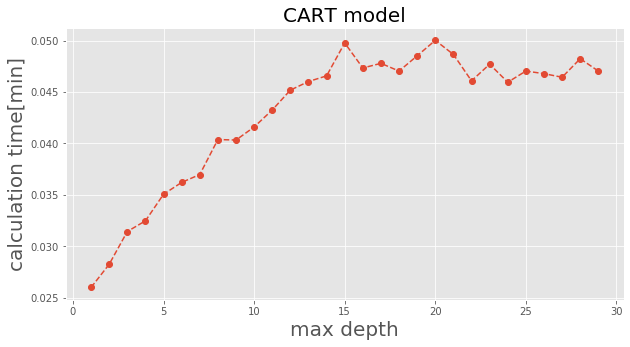

In [81]:
plt.figure(figsize = (10,5) )
plt.style.use('ggplot')
i = range(1,30)
# plt.plot(i,KNN_cvscores,color='green', marker='o', linestyle='dashed')
plt.plot(i,CART_time,marker='o',linestyle='--')
plt.title('CART model',{'fontsize' : 20})
plt.ylabel('calculation time[min]',{'fontsize' : 20})
plt.xlabel('max depth',{'fontsize' : 20})
plt.show()

# Stacking dataset produce

In [18]:
# from sklearn import cross_validation

seed = 42
np.random.seed(seed)

# X_train, X_test, Y_train, Y_test = np.load('./img_data.npy',allow_pickle=True)
skfolds=StratifiedKFold(n_splits=2, random_state=42,shuffle =True)
kfolds = KFold(5,shuffle=True)

RES_history = []
RES_cvscores = []

Y_train_recovery = np.argmax(Y_train, axis=1)

def train_and_validate():
    start_time = time.time()
    count = 0    
    pred = []
    answer = []

    for train_index, val_index in skfolds.split(x_train, Y_train_recovery):
        RES = InceptionV3(0.08492 ,18,0.3161)

        print('%d'%count,'train data:', len(train_index), 'validation data:', len(val_index))
        X_skftrain, X_val = X_train[train_index],X_train[val_index]
        Y_skftrain, Y_val = Y_train[train_index],Y_train[val_index]
#         data_flow = generator.flow(X_skftrain,Y_skftrain, batch_size = 200)

        
#         RES_history.append(RES.fit_generator(data_flow, epochs=30, steps_per_epoch=len(X_skftrain)/200,
#                                   verbose=2, validation_data=(X_val, Y_val)))
        model_time = time.time()
        
        RES_history.append(RES.fit(X_skftrain, Y_skftrain ,epochs=10, batch_size=2000, validation_data=(X_val, Y_val),verbose=2))
        
        print('RES run time :',round(time.time()-model_time,3)/60)      

        scores = RES.evaluate(X_val,Y_val, verbose=0)
        
        pred.append(RES.predict(X_val))
        f1scores =  f1_score(np.argmax(Y_test,axis=1),np.argmax(RES.predict(X_test),axis=1),average = 'weighted',
                             labels=np.unique(np.argmax(RES.predict(X_val),axis=1)))


#         kappascore = cohen_kappa_score(np.argmax(Y_val,axis=1),RES.predict_classes(X_val, verbose=0),labels=9,weights='linear')
        
        answer.append(Y_val)
        
        print("%s: %.2f%%" % (RES.metrics_names[1], scores[1]*100))
        print("f1scores RES",f1scores)
#         print("kappa scores RES",kappascore)
        
        RES_cvscores.append(scores[1] * 100)
        
#     save model
        
        filename = 'models/RESmodel_' + str(count + 1) + '.h5'
        RES.save(filename)
        print('>Saved %s' % filename)
               
        count+=1
       
    
    print("%.2f%% (+/- %.2f%%)" % (np.mean(RES_cvscores), np.std(RES_cvscores)))

    best_val_score = [np.max(RES_cvscores)]
    print('run time :',np.round(time.time()-start_time,3)/60)
    return best_val_score, pred, answer


best_val_score, pred, answer = train_and_validate()

ValueError: Input 0 is incompatible with layer conv2d_151: expected ndim=4, found ndim=5

In [15]:
# from sklearn import cross_validation
from keras.preprocessing.image import ImageDataGenerator


seed = 42
np.random.seed(seed)

# X_train, X_test, Y_train, Y_test = np.load('./img_data.npy',allow_pickle=True)
skfolds=StratifiedKFold(n_splits=5, random_state=42,shuffle =True)
kfolds = KFold(5,shuffle=True)

RES_history = []
RES_cvscores = []

Y_train_recovery = np.argmax(Y_train, axis=1)
generator = ImageDataGenerator(featurewise_center =True,rotation_range = 20,
                               zca_whitening=True, width_shift_range=0.1, height_shift_range=0.1)
generator.fit(X_train)

def train_and_validate():
    start_time = time.time()
    count = 0    
    pred = []
    answer = []

    for train_index, val_index in skfolds.split(X_train, Y_train_recovery):
        RES = vgg16_model(0.08492 ,18,0.3161)

        
        print('%d'%count,'train data:', len(train_index), 'validation data:', len(val_index))
        X_skftrain, X_val = X_train[train_index],X_train[val_index]
        Y_skftrain, Y_val = Y_train[train_index],Y_train[val_index]
                
    
        data_flow = generator.flow(X_skftrain,Y_skftrain, batch_size = 200)
        
        model_time = time.time()
        
#         RES_history.append(RES.fit_generator(data_flow, epochs=30, steps_per_epoch=len(X_skftrain)/200,
#                                   verbose=2, validation_data=(X_val, Y_val)))
        
        RES_history.append(RES.fit(X_skftrain, Y_skftrain ,epochs=10, batch_size=2000, validation_data=(X_val, Y_val),verbose=2))

        
        print('RES run time :',round(time.time()-model_time,3)/60)      

        scores = RES.evaluate(X_test,Y_test, verbose=0)
        
        pred.append(RES.predict(X_val))
        f1scores =  f1_score(np.argmax(Y_test,axis=1),np.argmax(RES.predict(X_test),axis=1),average = 'weighted',
                             labels=np.unique(np.argmax(RES.predict(X_val),axis=1)))


#         kappascore = cohen_kappa_score(np.argmax(Y_val,axis=1),RES.predict_classes(X_val, verbose=0),labels=9,weights='linear')
        
        answer.append(Y_val)
        
        print("%s: %.2f%%" % (RES.metrics_names[1], scores[1]*100))
        print("f1scores RES",f1scores)
#         print("kappa scores RES",kappascore)
        
        RES_cvscores.append(scores[1] * 100)
        
#     save model
        
        filename = 'models/VGG16net_model_' + str(count + 1) + '.h5'
        RES.save(filename)
        print('>Saved %s' % filename)
               
        count+=1
       
    
    print("%.2f%% (+/- %.2f%%)" % (np.mean(RES_cvscores), np.std(RES_cvscores)))

    best_val_score = [np.max(RES_cvscores)]
    print('run time :',np.round(time.time()-start_time,3)/60)
    return best_val_score, pred, answer


best_val_score, pred, answer = train_and_validate()

0 train data: 23592 validation data: 5899
Train on 23592 samples, validate on 5899 samples
Epoch 1/10
 - 5s - loss: 1.6535 - acc: 0.4902 - val_loss: 1.8076 - val_acc: 0.4246
Epoch 2/10
 - 5s - loss: 0.8608 - acc: 0.7293 - val_loss: 1.6104 - val_acc: 0.5586
Epoch 3/10
 - 5s - loss: 0.5198 - acc: 0.8269 - val_loss: 1.4438 - val_acc: 0.6343
Epoch 4/10
 - 5s - loss: 0.3243 - acc: 0.8921 - val_loss: 1.2883 - val_acc: 0.6903
Epoch 5/10
 - 5s - loss: 0.1921 - acc: 0.9390 - val_loss: 1.1356 - val_acc: 0.7328
Epoch 6/10
 - 5s - loss: 0.1206 - acc: 0.9628 - val_loss: 0.9824 - val_acc: 0.7588
Epoch 7/10
 - 5s - loss: 0.0779 - acc: 0.9789 - val_loss: 0.8973 - val_acc: 0.7913
Epoch 8/10
 - 5s - loss: 0.0602 - acc: 0.9841 - val_loss: 0.9336 - val_acc: 0.8169
Epoch 9/10
 - 5s - loss: 0.0455 - acc: 0.9888 - val_loss: 0.7244 - val_acc: 0.9280
Epoch 10/10
 - 5s - loss: 0.0294 - acc: 0.9935 - val_loss: 0.6407 - val_acc: 0.8866
RES run time : 0.81305
acc: 88.25%
f1scores RES 0.8662116579239832
>Saved mode

In [10]:
a = time.time()
round(time.time() - a,3) / 60

0.0

In [43]:
# from sklearn import cross_validation

seed = 7
np.random.seed(seed)

# X_train, X_test, Y_train, Y_test = np.load('./img_data.npy',allow_pickle=True)
skfolds=StratifiedKFold(n_splits=5, random_state=42,shuffle =True)
kfolds = KFold(5,shuffle=True)

CNN_history = []
CNN_cvscores = []

RES_history = []
RES_cvscores = []

KNN_history = []
KNN_cvscores = []

CART_history = []
CART_cvscores = []

Y_train_recovery = np.argmax(Y_train, axis=1)


def train_and_validate():
    start_time = time.time()
    count = 0    
    pred1 = []
    pred2 = []
    pred3 = []
    pred4 = []
    answer = []

    for train_index, val_index in skfolds.split(x, Y_class_recovery):
        CNN = vgg16_model(0.05566,5,0.4412)
        RES = InceptionV3(0.08492 ,18,0.3161)        

        print('%d'%count,'train data:', len(train_index), 'validation data:', len(val_index))
        x_skftrain, x_val = x[train_index],x[val_index]
        X_skftrain, X_val = X[train_index],X[val_index]
        Y_skftrain, Y_val = Y_class_onehot[train_index],Y_class_onehot[val_index]
        
               
        KNN = KNeighborsClassifier(n_neighbors=7)
        KNN_history.append(KNN.fit(x_skftrain, Y_skftrain))

        CART = tree.DecisionTreeClassifier(max_depth=9,min_samples_leaf=250,min_samples_split=9)
        CART_history.append(CART.fit(x_skftrain, Y_skftrain))
        
        CNN_history.append(CNN.fit_generator(data_flow, epochs=20,steps_per_epoch = 100,
                           verbose=2, validation_data=data_valflow,validation_steps = 200))

        RES_history.append(RES.fit_generator(data_flow, epochs=20,steps_per_epoch = 100,
                           verbose=2, validation_data=data_valflow,validation_steps = 200))

        
    # test
#         scores1 = KNN.evaluate(x_val,Y_val, verbose=0)
        pred1.append(KNN.predict(x_val))
        f1scores1 = f1_score(np.argmax(Y_val,axis=1),np.argmax(KNN.predict(x_val),axis=1),average = 'weighted',
                            labels=np.unique(np.argmax(KNN.predict(x_val),axis=1)))
        
#         scores2 = CART.score(x_val,Y_val)
        pred2.append(CART.predict(x_val))
        f1scores2 =  f1_score(np.argmax(Y_val,axis=1),np.argmax(CART.predict(x_val),axis=1),average = 'weighted',
                             labels=np.unique(np.argmax(CART.predict(x_val),axis=1)))

#         scores3 = CNN.evaluate(X_val,Y_val, verbose=0)
        pred3.append(CNN.predict(X_val))
        f1scores3 = f1_score(np.argmax(Y_test,axis=1),np.argmax(CNN.predict(X_test),axis=1),average = 'weighted',labels=np.unique(np.argmax(CNN.predict(X_test),axis=1)))

#         scores4 = RES.evaluate(X_val,Y_val, verbose=0)
        pred4.append(RES.predict(X_val))
        f1scores4 =  f1_score(np.argmax(Y_test,axis=1),np.argmax(RES.predict(X_test),axis=1),average = 'weighted',labels=np.unique(np.argmax(RES.predict(X_test),axis=1)))


        answer.append(Y_val)        

#         print("%.2f%%" % (scores1*100))
        print("f1scores KNN",f1scores1)
        KNN_cvscores.append(f1scores1)
                
#         print("%.2f%%" % (scores2*100))
        print("f1scores CART",f1scores2)
        CART_cvscores.append(f1scores2)
        
#         print("%s: %.2f%%" % (CNN.metrics_names[1], scores2[1]*100))
        print("f1scores CNN",f1scores3)
        CNN_cvscores.append(f1scores3)

        
#         print("%s: %.2f%%" % (RES.metrics_names[1], scores3[1]*100))
        print("f1scores RES",f1scores4)
        RES_cvscores.append(f1scores4)

       
        count+=1
        
    
    print("%.2f%% (+/- %.2f%%)" % (np.mean(CNN_cvscores), np.std(CNN_cvscores)))
    print("%.2f%% (+/- %.2f%%)" % (np.mean(RES_cvscores), np.std(RES_cvscores)))
    print("%.2f%% (+/- %.2f%%)" % (np.mean(KNN_cvscores), np.std(KNN_cvscores)))
    print("%.2f%% (+/- %.2f%%)" % (np.mean(CART_cvscores), np.std(CART_cvscores)))

    best_val_score = [np.max(KNN_cvscores),np.max(CART_cvscores),np.max(CNN_cvscores),np.max(RES_cvscores)]
    return best_val_score, pred1,pred2,pred3, pred4, answer


best_val_score, pred1,pred2,pred3, pred4, answer = train_and_validate()


# for i in range(len(MLP_history)):
#     plt.plot(MLP_history[i].history['accuracy'])
#     plt.plot(MLP_history[i].history['val_accuracy'])
#     plt.title('MLP model',{'fontsize' : 20})
#     plt.ylabel('Accuracy',{'fontsize' : 20})
#     plt.xlabel('Epoch',{'fontsize' : 20})
#     plt.legend(['Train', 'Test'], loc='upper left')
#     plt.show()

0 train data: 29491 validation data: 7373
Epoch 1/20


C:\Users\user\.conda\envs\cuda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\user\.conda\envs\cuda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 - 193s - loss: 2.6285 - accuracy: 0.1522 - val_loss: 1.7070 - val_accuracy: 0.6294
Epoch 2/20
 - 187s - loss: 2.1487 - accuracy: 0.2815 - val_loss: 1.3103 - val_accuracy: 0.6917
Epoch 3/20
 - 183s - loss: 1.8361 - accuracy: 0.3838 - val_loss: 1.0366 - val_accuracy: 0.7022
Epoch 4/20
 - 181s - loss: 1.6251 - accuracy: 0.4768 - val_loss: 0.8341 - val_accuracy: 0.7160
Epoch 5/20
 - 180s - loss: 1.4786 - accuracy: 0.5330 - val_loss: 0.9528 - val_accuracy: 0.7219
Epoch 6/20
 - 179s - loss: 1.3438 - accuracy: 0.5870 - val_loss: 0.8826 - val_accuracy: 0.7378
Epoch 7/20
 - 179s - loss: 1.2180 - accuracy: 0.6298 - val_loss: 0.6359 - val_accuracy: 0.7493
Epoch 8/20
 - 179s - loss: 1.1986 - accuracy: 0.6496 - val_loss: 0.5812 - val_accuracy: 0.7646
Epoch 9/20
 - 180s - loss: 1.1004 - accuracy: 0.6750 - val_loss: 0.7605 - val_accuracy: 0.7743
Epoch 10/20
 - 179s - loss: 1.0500 - accuracy: 0.6992 - val_loss: 0.4961 - val_accuracy: 0.7898
Epoch 11/20
 - 179s - loss: 1.0162 - accuracy: 0.7108 - val_

C:\Users\user\.conda\envs\cuda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\user\.conda\envs\cuda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\user\.conda\envs\cuda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\user\.conda\envs\cuda\lib\site-packages\keras_prepr

Epoch 1/20


C:\Users\user\.conda\envs\cuda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\user\.conda\envs\cuda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 - 186s - loss: 2.7336 - accuracy: 0.1384 - val_loss: 1.9351 - val_accuracy: 0.3287
Epoch 2/20
 - 180s - loss: 2.5322 - accuracy: 0.1748 - val_loss: 1.5954 - val_accuracy: 0.6158
Epoch 3/20
 - 179s - loss: 2.3242 - accuracy: 0.2208 - val_loss: 1.3265 - val_accuracy: 0.6470
Epoch 4/20
 - 179s - loss: 2.1634 - accuracy: 0.2744 - val_loss: 1.3722 - val_accuracy: 0.6527
Epoch 5/20
 - 179s - loss: 1.9859 - accuracy: 0.3252 - val_loss: 1.1575 - val_accuracy: 0.6585
Epoch 6/20
 - 179s - loss: 1.8756 - accuracy: 0.3746 - val_loss: 1.3729 - val_accuracy: 0.6624
Epoch 7/20
 - 179s - loss: 1.7319 - accuracy: 0.4178 - val_loss: 1.0708 - val_accuracy: 0.6736
Epoch 8/20
 - 179s - loss: 1.6086 - accuracy: 0.4770 - val_loss: 1.0985 - val_accuracy: 0.6834
Epoch 9/20
 - 178s - loss: 1.4957 - accuracy: 0.5166 - val_loss: 1.1337 - val_accuracy: 0.6781
Epoch 10/20
 - 179s - loss: 1.4324 - accuracy: 0.5592 - val_loss: 0.6042 - val_accuracy: 0.6926
Epoch 11/20
 - 179s - loss: 1.3998 - accuracy: 0.5762 - val_

C:\Users\user\.conda\envs\cuda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\user\.conda\envs\cuda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


f1scores KNN 0.9090886842138419
f1scores CART 0.8640416169390269
f1scores CNN 0.8167609401188363
f1scores RES 0.7806767663325896
1 train data: 29491 validation data: 7373
Epoch 1/20


C:\Users\user\.conda\envs\cuda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\user\.conda\envs\cuda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 - 185s - loss: 2.5783 - accuracy: 0.1537 - val_loss: 1.6134 - val_accuracy: 0.6178
Epoch 2/20
 - 179s - loss: 2.1578 - accuracy: 0.2526 - val_loss: 1.3700 - val_accuracy: 0.6699
Epoch 3/20
 - 179s - loss: 1.8256 - accuracy: 0.3898 - val_loss: 1.0031 - val_accuracy: 0.6718
Epoch 4/20
 - 178s - loss: 1.6537 - accuracy: 0.4658 - val_loss: 0.9342 - val_accuracy: 0.7017
Epoch 5/20
 - 179s - loss: 1.4573 - accuracy: 0.5384 - val_loss: 0.9102 - val_accuracy: 0.7120
Epoch 6/20
 - 179s - loss: 1.3591 - accuracy: 0.5900 - val_loss: 0.6664 - val_accuracy: 0.7300
Epoch 7/20
 - 179s - loss: 1.2829 - accuracy: 0.6144 - val_loss: 0.6194 - val_accuracy: 0.7466
Epoch 8/20
 - 178s - loss: 1.1457 - accuracy: 0.6662 - val_loss: 0.5487 - val_accuracy: 0.7576
Epoch 9/20
 - 179s - loss: 1.1353 - accuracy: 0.6676 - val_loss: 0.7609 - val_accuracy: 0.7832
Epoch 10/20
 - 178s - loss: 1.0867 - accuracy: 0.6838 - val_loss: 0.6644 - val_accuracy: 0.7789
Epoch 11/20
 - 179s - loss: 1.0368 - accuracy: 0.7177 - val_

C:\Users\user\.conda\envs\cuda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\user\.conda\envs\cuda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\user\.conda\envs\cuda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\user\.conda\envs\cuda\lib\site-packages\keras_prepr

Epoch 1/20


C:\Users\user\.conda\envs\cuda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\user\.conda\envs\cuda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 - 187s - loss: 2.7023 - accuracy: 0.1208 - val_loss: 2.2683 - val_accuracy: 0.0386
Epoch 2/20
 - 181s - loss: 2.5090 - accuracy: 0.1693 - val_loss: 1.9614 - val_accuracy: 0.2002
Epoch 3/20
 - 181s - loss: 2.3290 - accuracy: 0.2122 - val_loss: 1.9427 - val_accuracy: 0.3423
Epoch 4/20
 - 181s - loss: 2.1664 - accuracy: 0.2582 - val_loss: 1.6912 - val_accuracy: 0.4882
Epoch 5/20
 - 181s - loss: 2.0331 - accuracy: 0.3088 - val_loss: 1.4762 - val_accuracy: 0.5715
Epoch 6/20
 - 180s - loss: 1.9061 - accuracy: 0.3606 - val_loss: 1.2389 - val_accuracy: 0.6509
Epoch 7/20
 - 182s - loss: 1.7618 - accuracy: 0.4266 - val_loss: 0.9456 - val_accuracy: 0.6848
Epoch 8/20
 - 180s - loss: 1.6624 - accuracy: 0.4608 - val_loss: 1.0742 - val_accuracy: 0.7183
Epoch 9/20
 - 181s - loss: 1.5356 - accuracy: 0.5172 - val_loss: 1.0182 - val_accuracy: 0.7316
Epoch 10/20
 - 181s - loss: 1.4633 - accuracy: 0.5436 - val_loss: 0.8739 - val_accuracy: 0.7448
Epoch 11/20
 - 182s - loss: 1.3646 - accuracy: 0.5798 - val_

C:\Users\user\.conda\envs\cuda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\user\.conda\envs\cuda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


f1scores KNN 0.9027857753884171
f1scores CART 0.8649880652639279
f1scores CNN 0.8093920330383666
f1scores RES 0.8161049547409107
2 train data: 29491 validation data: 7373
Epoch 1/20


C:\Users\user\.conda\envs\cuda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\user\.conda\envs\cuda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 - 194s - loss: 2.6031 - accuracy: 0.1563 - val_loss: 1.8443 - val_accuracy: 0.4915
Epoch 2/20
 - 186s - loss: 2.1331 - accuracy: 0.2724 - val_loss: 1.1029 - val_accuracy: 0.6874
Epoch 3/20
 - 185s - loss: 1.8176 - accuracy: 0.4060 - val_loss: 0.9485 - val_accuracy: 0.6946
Epoch 4/20
 - 184s - loss: 1.6298 - accuracy: 0.4790 - val_loss: 0.9412 - val_accuracy: 0.7057
Epoch 5/20
 - 183s - loss: 1.4367 - accuracy: 0.5616 - val_loss: 0.8381 - val_accuracy: 0.7162
Epoch 6/20
 - 186s - loss: 1.2921 - accuracy: 0.6062 - val_loss: 0.7453 - val_accuracy: 0.7193
Epoch 7/20
 - 186s - loss: 1.1960 - accuracy: 0.6312 - val_loss: 1.0033 - val_accuracy: 0.7546
Epoch 8/20
 - 186s - loss: 1.1220 - accuracy: 0.6686 - val_loss: 0.8455 - val_accuracy: 0.7654
Epoch 9/20
 - 186s - loss: 1.0816 - accuracy: 0.6846 - val_loss: 0.5979 - val_accuracy: 0.7777
Epoch 10/20
 - 187s - loss: 1.0623 - accuracy: 0.6980 - val_loss: 0.6479 - val_accuracy: 0.7968
Epoch 11/20
 - 186s - loss: 0.9818 - accuracy: 0.7182 - val_

C:\Users\user\.conda\envs\cuda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\user\.conda\envs\cuda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\user\.conda\envs\cuda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\user\.conda\envs\cuda\lib\site-packages\keras_prepr

Epoch 1/20


C:\Users\user\.conda\envs\cuda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\user\.conda\envs\cuda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 - 196s - loss: 2.7603 - accuracy: 0.1300 - val_loss: 2.0787 - val_accuracy: 0.2927
Epoch 2/20
 - 189s - loss: 2.5396 - accuracy: 0.1718 - val_loss: 1.8853 - val_accuracy: 0.3216
Epoch 3/20
 - 188s - loss: 2.3947 - accuracy: 0.2092 - val_loss: 1.7930 - val_accuracy: 0.4501
Epoch 4/20
 - 189s - loss: 2.2137 - accuracy: 0.2569 - val_loss: 1.6047 - val_accuracy: 0.5641
Epoch 5/20
 - 188s - loss: 2.0805 - accuracy: 0.3146 - val_loss: 1.4515 - val_accuracy: 0.6471
Epoch 6/20
 - 189s - loss: 1.9581 - accuracy: 0.3564 - val_loss: 1.2967 - val_accuracy: 0.6915
Epoch 7/20
 - 189s - loss: 1.8156 - accuracy: 0.4068 - val_loss: 1.1249 - val_accuracy: 0.7303
Epoch 8/20
 - 184s - loss: 1.6642 - accuracy: 0.4600 - val_loss: 0.9482 - val_accuracy: 0.7481
Epoch 9/20
 - 182s - loss: 1.5809 - accuracy: 0.4892 - val_loss: 0.8449 - val_accuracy: 0.7509
Epoch 10/20
 - 183s - loss: 1.4684 - accuracy: 0.5390 - val_loss: 0.8842 - val_accuracy: 0.7636
Epoch 11/20
 - 183s - loss: 1.3869 - accuracy: 0.5742 - val_

C:\Users\user\.conda\envs\cuda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\user\.conda\envs\cuda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


f1scores KNN 0.9098994035499055
f1scores CART 0.8690769636449746
f1scores CNN 0.8345775231041259
f1scores RES 0.8064361063697764
3 train data: 29491 validation data: 7373
Epoch 1/20


C:\Users\user\.conda\envs\cuda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\user\.conda\envs\cuda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 - 192s - loss: 2.5869 - accuracy: 0.1850 - val_loss: 1.8168 - val_accuracy: 0.5623
Epoch 2/20
 - 184s - loss: 2.1030 - accuracy: 0.3106 - val_loss: 1.1083 - val_accuracy: 0.6681
Epoch 3/20
 - 183s - loss: 1.8127 - accuracy: 0.4002 - val_loss: 0.9560 - val_accuracy: 0.6732
Epoch 4/20
 - 184s - loss: 1.6135 - accuracy: 0.4774 - val_loss: 0.8853 - val_accuracy: 0.6887
Epoch 5/20
 - 186s - loss: 1.4594 - accuracy: 0.5434 - val_loss: 0.9020 - val_accuracy: 0.6902
Epoch 6/20
 - 188s - loss: 1.3479 - accuracy: 0.5982 - val_loss: 0.8818 - val_accuracy: 0.7070
Epoch 7/20
 - 185s - loss: 1.2506 - accuracy: 0.6357 - val_loss: 0.8681 - val_accuracy: 0.7201
Epoch 8/20
 - 186s - loss: 1.1451 - accuracy: 0.6574 - val_loss: 1.2220 - val_accuracy: 0.7338
Epoch 9/20
 - 186s - loss: 1.0612 - accuracy: 0.6924 - val_loss: 0.7428 - val_accuracy: 0.7425
Epoch 10/20
 - 185s - loss: 1.0140 - accuracy: 0.7092 - val_loss: 0.8127 - val_accuracy: 0.7630
Epoch 11/20
 - 185s - loss: 0.9605 - accuracy: 0.7296 - val_

C:\Users\user\.conda\envs\cuda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\user\.conda\envs\cuda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\user\.conda\envs\cuda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\user\.conda\envs\cuda\lib\site-packages\keras_prepr

Epoch 1/20


C:\Users\user\.conda\envs\cuda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\user\.conda\envs\cuda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 - 189s - loss: 2.7512 - accuracy: 0.1348 - val_loss: 1.9662 - val_accuracy: 0.2233
Epoch 2/20
 - 182s - loss: 2.5319 - accuracy: 0.1795 - val_loss: 1.6578 - val_accuracy: 0.4592
Epoch 3/20
 - 182s - loss: 2.3278 - accuracy: 0.2312 - val_loss: 1.3873 - val_accuracy: 0.5653
Epoch 4/20
 - 182s - loss: 2.1321 - accuracy: 0.2798 - val_loss: 1.2907 - val_accuracy: 0.6386
Epoch 5/20
 - 183s - loss: 1.9509 - accuracy: 0.3534 - val_loss: 1.1960 - val_accuracy: 0.6677
Epoch 6/20
 - 183s - loss: 1.7856 - accuracy: 0.4096 - val_loss: 1.1772 - val_accuracy: 0.6725
Epoch 7/20
 - 182s - loss: 1.6791 - accuracy: 0.4522 - val_loss: 1.1619 - val_accuracy: 0.6765
Epoch 8/20
 - 186s - loss: 1.5790 - accuracy: 0.4954 - val_loss: 0.6074 - val_accuracy: 0.6895
Epoch 9/20
 - 182s - loss: 1.4123 - accuracy: 0.5640 - val_loss: 1.2528 - val_accuracy: 0.6905
Epoch 10/20
 - 182s - loss: 1.3745 - accuracy: 0.5772 - val_loss: 0.7091 - val_accuracy: 0.7092
Epoch 11/20
 - 182s - loss: 1.2691 - accuracy: 0.6153 - val_

C:\Users\user\.conda\envs\cuda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\user\.conda\envs\cuda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


f1scores KNN 0.9083671943112716
f1scores CART 0.8720323738056812
f1scores CNN 0.8127291267683656
f1scores RES 0.8167002802248805
4 train data: 29492 validation data: 7372
Epoch 1/20


C:\Users\user\.conda\envs\cuda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\user\.conda\envs\cuda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 - 189s - loss: 2.4775 - accuracy: 0.1716 - val_loss: 1.5058 - val_accuracy: 0.6129
Epoch 2/20
 - 183s - loss: 2.0507 - accuracy: 0.2875 - val_loss: 1.1779 - val_accuracy: 0.6948
Epoch 3/20
 - 183s - loss: 1.7665 - accuracy: 0.3976 - val_loss: 0.9361 - val_accuracy: 0.7071
Epoch 4/20
 - 182s - loss: 1.5928 - accuracy: 0.4810 - val_loss: 0.7943 - val_accuracy: 0.7084
Epoch 5/20
 - 182s - loss: 1.4467 - accuracy: 0.5376 - val_loss: 0.7342 - val_accuracy: 0.7400
Epoch 6/20
 - 182s - loss: 1.2933 - accuracy: 0.5994 - val_loss: 0.6186 - val_accuracy: 0.7581
Epoch 7/20
 - 181s - loss: 1.2101 - accuracy: 0.6436 - val_loss: 0.7187 - val_accuracy: 0.7604
Epoch 8/20
 - 181s - loss: 1.1473 - accuracy: 0.6608 - val_loss: 0.6513 - val_accuracy: 0.7669
Epoch 9/20
 - 181s - loss: 1.1068 - accuracy: 0.6854 - val_loss: 0.6021 - val_accuracy: 0.7822
Epoch 10/20
 - 181s - loss: 1.0358 - accuracy: 0.7084 - val_loss: 0.8401 - val_accuracy: 0.7927
Epoch 11/20
 - 181s - loss: 1.0150 - accuracy: 0.7264 - val_

C:\Users\user\.conda\envs\cuda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\user\.conda\envs\cuda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\user\.conda\envs\cuda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\user\.conda\envs\cuda\lib\site-packages\keras_prepr

Epoch 1/20


C:\Users\user\.conda\envs\cuda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\user\.conda\envs\cuda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


 - 192s - loss: 2.7202 - accuracy: 0.1306 - val_loss: 2.2889 - val_accuracy: 0.1925
Epoch 2/20
 - 186s - loss: 2.4885 - accuracy: 0.1782 - val_loss: 1.8515 - val_accuracy: 0.3635
Epoch 3/20
 - 185s - loss: 2.3175 - accuracy: 0.2260 - val_loss: 1.6397 - val_accuracy: 0.5248
Epoch 4/20
 - 186s - loss: 2.1562 - accuracy: 0.2708 - val_loss: 1.3248 - val_accuracy: 0.6318
Epoch 5/20
 - 187s - loss: 1.9582 - accuracy: 0.3390 - val_loss: 1.2688 - val_accuracy: 0.7044
Epoch 6/20
 - 187s - loss: 1.8186 - accuracy: 0.3948 - val_loss: 1.1746 - val_accuracy: 0.7195
Epoch 7/20
 - 186s - loss: 1.7052 - accuracy: 0.4300 - val_loss: 1.0207 - val_accuracy: 0.7416
Epoch 8/20
 - 185s - loss: 1.5334 - accuracy: 0.5048 - val_loss: 1.2646 - val_accuracy: 0.7473
Epoch 9/20
 - 188s - loss: 1.4248 - accuracy: 0.5400 - val_loss: 0.8900 - val_accuracy: 0.7629
Epoch 10/20
 - 185s - loss: 1.3747 - accuracy: 0.5792 - val_loss: 0.8419 - val_accuracy: 0.7669
Epoch 11/20
 - 185s - loss: 1.3022 - accuracy: 0.6050 - val_

C:\Users\user\.conda\envs\cuda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\user\.conda\envs\cuda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


f1scores KNN 0.9138959124659821
f1scores CART 0.8799708122957083
f1scores CNN 0.8171067355478436
f1scores RES 0.856702507682657
0.82% (+/- 0.01%)
0.82% (+/- 0.02%)
0.91% (+/- 0.00%)
0.87% (+/- 0.01%)


In [44]:
CART_cvscores

[0.8640416169390269,
 0.8649880652639279,
 0.8690769636449746,
 0.8720323738056812,
 0.8799708122957083]

In [31]:
print(np.argmax(pred2[0], axis=1))

[0 0 0 ... 8 8 8]


In [56]:
M1 = []
M2 = []
M3 = []
M4 = []
MetaY = []
for i in range(5):
#     M1 = np.concatenate((M1,np.argmax(pred1[i], axis=1)))
    M1 = np.concatenate((M1,np.argmax(pred1[i], axis=1)))
#     M3 = np.concatenate((M3,np.argmax(pred3[i], axis=1)))
    M3 = np.concatenate((M3,np.argmax(pred3[i], axis=1)))
    MetaY = np.concatenate((MetaY,np.argmax(answer[i], axis=1)))

In [57]:
Metadata = pd.DataFrame(data=[M1,M3,MetaY])

In [58]:
Metadata = Metadata.T

In [59]:
Metadata.columns = ['K-NN Predict','VGG-16 Predict','Y']
Metadata.describe()

,K-NN Predict,VGG-16 Predict,Y
count,36864.000000,36864.000000,36864.000000
mean,3.775499,3.711778,3.937500
std,1.701100,1.577180,1.722321
min,0.000000,0.000000,0.000000
25%,3.000000,3.000000,3.000000
50%,4.000000,4.000000,4.000000
75%,4.000000,4.000000,4.000000
max,8.000000,8.000000,8.000000


# Metadata create

In [60]:
Metadata_train = np.array(Metadata.iloc[:,[0,1]])
Metadata_Y = np.array(Metadata.iloc[:,[2]])

In [61]:
Meta_Y_class = np.array(Metadata_Y).reshape(-1,1)
enc = OneHotEncoder()
enc.fit(Meta_Y_class)
Meta_Y_class_onehot = enc.transform(Meta_Y_class).toarray()

In [62]:
print((Meta_Y_class_onehot.shape))

(36864, 9)


In [63]:
print((Y_class_onehot))

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


# Stacking model

In [111]:
def ensemble_model():
    ensemble = Sequential()
    ensemble.add(Dense(1024, input_dim=2, activation="relu", kernel_initializer="normal"))
    ensemble.add(Dropout(0.3, name='Dropout_Regularization')) 
    ensemble.add(Dense(1024, activation="relu", kernel_initializer="normal"))
    ensemble.add(Dense(9, activation="softmax", kernel_initializer="normal"))
    # Compile model
    ensemble.compile(loss='categorical_crossentropy', optimizer= Adam(lr=0.0001), metrics=['accuracy'])
#     MLP.summary()
    ## Fit the model
    return ensemble

# ensemble model process

In [112]:
Ensemble_history = []
start_time = time.time()
Ensemble_cvscores = []
count = 0
skfolds=StratifiedKFold(n_splits=5, random_state=42,shuffle =True)

for train_index, val_index in skfolds.split(Metadata_train, Metadata_Y):
    Ensemble = ensemble_model()

    print('%d' %count,'train data:', len(train_index), 'validation data:', len(val_index))
    x_skftrain, x_val = Metadata_train[train_index],Metadata_train[val_index]
    Y_skftrain, Y_val = Meta_Y_class_onehot[train_index],Meta_Y_class_onehot[val_index]
    

    Ensemble_history.append(Ensemble.fit(x_skftrain, Y_skftrain ,epochs=50, batch_size=200, verbose=0))
    
    predict = Ensemble.predict(x_val)
    y_val = np.argmax(Y_val,axis=1)
    pred = np.argmax(predict,axis=1)
    f1score = f1_score(y_val,pred,average = 'weighted')
    
    print('f1_score',f1score)
    Ensemble_cvscores.append(f1score)
    best_val_score = np.max(Ensemble_cvscores)
    count+=1
print('run time :',round(time.time()-start_time,3)/60)
print("%.2f%% (+/- %.2f%%)" % (np.mean(Ensemble_cvscores), np.std(Ensemble_cvscores)))

0 train data: 29491 validation data: 7373
f1_score 0.9316245706516068
1 train data: 29491 validation data: 7373
f1_score 0.9285169003094327
2 train data: 29491 validation data: 7373
f1_score 0.9249363213211993
3 train data: 29491 validation data: 7373
f1_score 0.9295884209784251
4 train data: 29492 validation data: 7372
f1_score 0.9236397777274334
run time : 3.7478333333333333
0.93% (+/- 0.00%)


In [60]:
y_val = np.argmax(Y_val,axis=1)
pred = np.argmax(predict,axis=1)
cm = confusion_matrix(y_val,pred)
print(cm)
f1_score(y_val,pred,average = 'macro')

[[198  50   0  30   3   0   0   0   0]
 [  3 309  23   3  64   6   0   0   0]
 [  1  78 168   0  24  55   0   1   2]
 [  9  43   0 231  99   6   0  20   0]
 [  0  29   2   0 472  47   0  36   7]
 [  0   6   6   0  70 318   1  42  34]
 [  1   3   2  67  39  36   1 170  10]
 [  0   1   0   0  71  88   0 259  58]
 [  0   1   1   0   4  70   0  59 249]]


0.5691100919367498

In [16]:
# load models from file
def load_all_models(n_models):
    all_models = list()
    for i in range(n_models):
        # define filename for this ensemble
        filename = 'models/MLPmodel_' + str(i + 1) + '.h5'
        # load model from file
        model = load_model(filename)
        # add to list of members
        all_models.append(model)
        print('>loaded %s' % filename)
    return all_models

In [17]:
# fit a stacked model
def fit_stacked_model(model, inputX, inputy):
    # prepare input data
    X = [inputX for _ in range(ulen(model.input))]
    # encode output data
    inputy_enc = to_categorical(inputy)
    # fir model
    model.fit(X, inputy_enc, epochs=300, verbose=0)

In [18]:
# load all models
n_members = 5
members = load_all_models(n_members)
print('Loaded %d models' % len(members))

# define ensemble model
stacked_model = define_stacked_model(members)

# fit stacked model on test dataset
fit_stacked_model(stacked_model, x_test, Y_test)

>loaded models/MLPmodel_1.h5
>loaded models/MLPmodel_2.h5
>loaded models/MLPmodel_3.h5
>loaded models/MLPmodel_4.h5
>loaded models/MLPmodel_5.h5
Loaded 5 models


ValueError: Error when checking target: expected dense_6 to have 2 dimensions, but got array with shape (36637, 9, 2)

In [23]:
mt = []
mtrash = []

In [24]:
for i in range(5):
    for j in range(30):
        mt.append(MLP_history[i].history['accuracy'][j])
        mtrash.append(MLP_history[i].history['val_accuracy'][j])

NameError: name 'MLP_history' is not defined

Text(0, 0.5, 'accuracy')

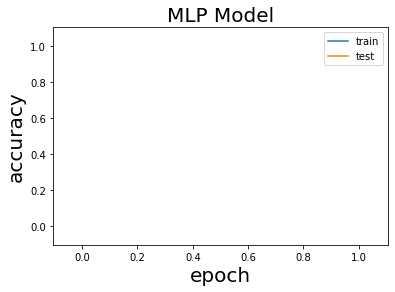

In [25]:
plt.plot(mt,label = 'train')
plt.plot(mtrash,label = 'test')
plt.title('MLP Model',{'fontsize' : 20})
plt.legend()
plt.xlabel('epoch',{'fontsize' : 20})
plt.ylabel('accuracy',{'fontsize' : 20})

# 딥러닝 모델

In [11]:
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adam, SGD, RMSprop, Nadam, Adamax, Adagrad, Adadelta
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers.normalization import BatchNormalization



CNN_search_point = {'learning_rate': (0.001,0.1),
                  'dense_node':(1,1024),
                  'dropout_rate':(0.1,0.5)}

skfolds=StratifiedKFold(n_splits=5, random_state=42,shuffle =True)

Y_train_recovery = np.argmax(Y_train, axis=1)

def CNN_opt(learning_rate,dense_node,dropout_rate):
    cvscores = []
    print(float(learning_rate),int(dense_node),float(dropout_rate))
    for train_index, valid_index in skfolds.split(X_train, Y_train_recovery):
        cnn = cnn_model(float(learning_rate),int(dense_node),float(dropout_rate))
        X_train_fold,X_valid_fold = X_train[train_index],X_train[valid_index]
        y_train_fold,y_valid_fold = Y_train[train_index],Y_train[valid_index]

        cnn.fit(X_train_fold,y_train_fold,batch_size=2, nb_epoch=5,verbose=0)
        score = cnn.evaluate(X_valid_fold,y_valid_fold,verbose=0)
        cvscores.append(score[1]*100)
    return np.mean(cvscores)


# if __name__ == "__main__":
#     result = BayesianOptimization(CNN_opt, CNN_search_point,    random_state=0,    verbose=2) 
#     result.maximize(acq='ucb',n_iter=20)
#     for i, res in enumerate(result.res):
#         print('Iteration {}: \n\t{}'.format(i, res))
#         print('Final result: ', result.max)

In [22]:
models = [mlp_model(),cnn_model(0.019589,225,0.18557)]

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
Dense_Intermediate (Dense)   (None, 512)               262656    
_________________________________________________________________
batch_normalization_3 (Batch (None, 512)               2048      
_________________________________________________________________
Dropout_Regularization (Drop (None, 512)               0         
_________________________________________________________________
Output (Dense)               (None, 9)                 4617      
Total params: 14,984,009
Trainable params: 268,297
Non-trainable params: 14,715,712
____________________________________

In [21]:
def CNN_opt(learning_rate,dense_node,dropout_rate):
    cvscores = []
    for train_index, valid_index in skfolds.split(X_train, Y_train_recovery):
        X_train_fold,X_valid_fold = X_train[train_index],X_train[valid_index]
        y_train_fold,y_valid_fold = Y_train[train_index],Y_train[valid_index]

        print(float(learning_rate),int(dense_node),float(dropout_rate))
        cnn = cnn_model(float(learning_rate),int(dense_node),float(dropout_rate)).fit(X_train_fold,y_train_fold,batch_size=400, nb_epoch=20,verbose=2)
        score = cnn_model(float(learning_rate),int(dense_node),float(dropout_rate)).evaluate(X_valid_fold,y_valid_fold,verbose=2)
        print(score)
        cvscores.append(score[1]*100)
    return np.mean(cvscores)

In [22]:
sc = CNN_opt(0.019589668000042214,225.47628273963673,0.18557181851054969)
print(sc)

0.019589668000042214 225 0.18557181851054969


KeyboardInterrupt: 

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 512)               0         
_________________________________________________________________
Dense_Intermediate (Dense)   (None, 512)               262656    
_________________________________________________________________
batch_normalization_10 (Batc (None, 512)               2048      
_________________________________________________________________
Dropout_Regularization (Drop (None, 512)               0         
_________________________________________________________________
Output (Dense)               (None, 9)                 4617      
Total params: 14,984,009
Trainable params: 268,297
Non-trainable params: 14,715,712
___________________________________

Epoch 31/50
 - 13s - loss: 0.4236 - accuracy: 0.8407
Epoch 32/50
 - 13s - loss: 0.4229 - accuracy: 0.8416
Epoch 33/50
 - 13s - loss: 0.4204 - accuracy: 0.8420
Epoch 34/50
 - 13s - loss: 0.4214 - accuracy: 0.8410
Epoch 35/50
 - 13s - loss: 0.4191 - accuracy: 0.8418
Epoch 36/50
 - 13s - loss: 0.4172 - accuracy: 0.8436
Epoch 37/50
 - 13s - loss: 0.4150 - accuracy: 0.8442
Epoch 38/50
 - 13s - loss: 0.4186 - accuracy: 0.8428
Epoch 39/50
 - 13s - loss: 0.4205 - accuracy: 0.8415
Epoch 40/50
 - 13s - loss: 0.4173 - accuracy: 0.8429
Epoch 41/50
 - 13s - loss: 0.4159 - accuracy: 0.8441
Epoch 42/50
 - 13s - loss: 0.4182 - accuracy: 0.8428
Epoch 43/50
 - 13s - loss: 0.4170 - accuracy: 0.8431
Epoch 44/50
 - 13s - loss: 0.4148 - accuracy: 0.8432
Epoch 45/50
 - 13s - loss: 0.4117 - accuracy: 0.8451
Epoch 46/50
 - 13s - loss: 0.4146 - accuracy: 0.8438
Epoch 47/50
 - 13s - loss: 0.4095 - accuracy: 0.8462
Epoch 48/50
 - 13s - loss: 0.4126 - accuracy: 0.8443
Epoch 49/50
 - 13s - loss: 0.4120 - accuracy: 

Epoch 31/50
 - 13s - loss: 0.4188 - accuracy: 0.8423
Epoch 32/50
 - 13s - loss: 0.4184 - accuracy: 0.8413
Epoch 33/50
 - 13s - loss: 0.4171 - accuracy: 0.8428
Epoch 34/50
 - 13s - loss: 0.4144 - accuracy: 0.8440
Epoch 35/50
 - 13s - loss: 0.4195 - accuracy: 0.8427
Epoch 36/50
 - 13s - loss: 0.4195 - accuracy: 0.8420
Epoch 37/50
 - 13s - loss: 0.4145 - accuracy: 0.8438
Epoch 38/50
 - 13s - loss: 0.4169 - accuracy: 0.8436
Epoch 39/50
 - 13s - loss: 0.4113 - accuracy: 0.8448
Epoch 40/50
 - 13s - loss: 0.4114 - accuracy: 0.8440
Epoch 41/50
 - 13s - loss: 0.4124 - accuracy: 0.8449
Epoch 42/50
 - 13s - loss: 0.4123 - accuracy: 0.8443
Epoch 43/50
 - 13s - loss: 0.4142 - accuracy: 0.8439
Epoch 44/50
 - 13s - loss: 0.4138 - accuracy: 0.8425
Epoch 45/50
 - 13s - loss: 0.4158 - accuracy: 0.8444
Epoch 46/50
 - 13s - loss: 0.4104 - accuracy: 0.8447
Epoch 47/50
 - 13s - loss: 0.4112 - accuracy: 0.8449
Epoch 48/50
 - 13s - loss: 0.4075 - accuracy: 0.8467
Epoch 49/50
 - 13s - loss: 0.4057 - accuracy: 

KeyError: 'val_accuracy'

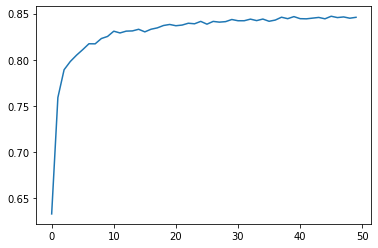

In [15]:
# X_train, X_test, Y_train, Y_test = np.load('./img_data.npy',allow_pickle=True) # Train:Test = 4:1 로 분할된 데이터

skfolds=StratifiedKFold(n_splits=5, random_state=42,shuffle =True)
kfolds = KFold(n_splits=5)

Y_train_recovery = np.argmax(Y_train, axis=1)

cnn_cvscores = []
CNN_history = []
start_time = time.time()

count=0
for train_index, valid_index in skfolds.split(X_train, Y_train_recovery):
    X_train_fold,X_valid_fold = X_train[train_index],X_train[valid_index]
    y_train_fold,y_valid_fold = Y_train[train_index],Y_train[valid_index]
    cnn = cnn_model(0.019589,225,0.18557)

    CNN_history.append(cnn.fit(X_train_fold, y_train_fold, batch_size=2000, epochs=50,verbose=2))

    scores = cnn.evaluate(X_valid_fold, y_valid_fold, verbose=1)
    print("%s: %.2f%%" % (cnn.metrics_names[1], scores[1]*100))
    cnn_cvscores.append(scores[1] * 100)
    
    # save model
    filename = 'models/CNNmodel_' + str(count + 1) + '.h5'
    cnn.save(filename)
    print('>Saved %s' % filename)
    count+=1


print("%.2f%% (+/- %.2f%%)" % (np.mean(cnn_cvscores), np.std(cnn_cvscores)))
cnn_best_val_score = np.max(cnn_cvscores)
print('run time :',round(time.time()-start_time,3)/60)


for i in range(len(CNN_history)):
    plt.plot(CNN_history[i].history['accuracy'])
    plt.plot(CNN_history[i].history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('Accuracy',{'fontsize' : 20})
    plt.xlabel('Epoch',{'fontsize' : 20})
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
# CNN_model.save('CNN_model.h5')

In [16]:
temp = []
trash = []

In [17]:
for i in range(5):
    for j in range(30):
        temp.append(CNN_history[i].history['accuracy'][j])
#         trash.append(CNN_history[i].history['val_accuracy'][j])

<function matplotlib.pyplot.box(on=None)>

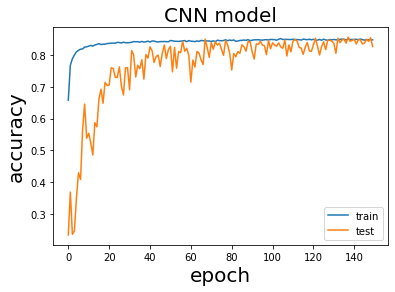

In [17]:
plt.plot(temp,label = 'train')
# plt.plot(trash,label = 'test')
plt.title('CNN model',{'fontsize' : 20})
plt.legend()
plt.ylabel('accuracy',{'fontsize' : 20})
plt.xlabel('epoch',{'fontsize' : 20})

plt.box

4.49% (+/- 3.27%)


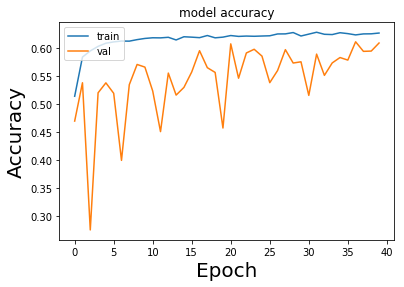

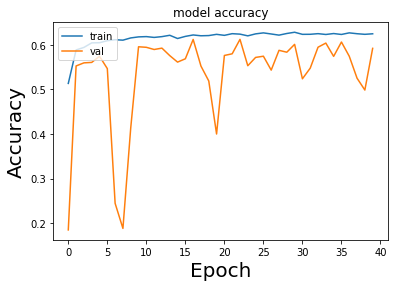

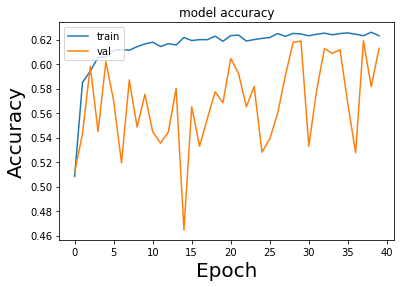

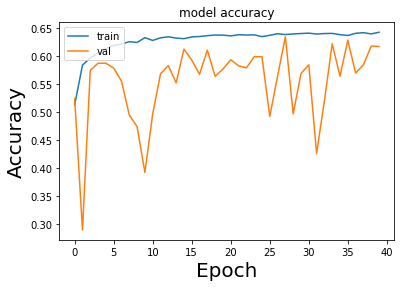

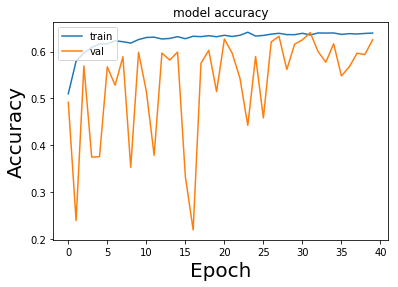

In [58]:
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

for i in range(len(CNN_history)):
    plt.plot(CNN_history[i].history['acc'])
    plt.plot(CNN_history[i].history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('Accuracy',{'fontsize' : 20})
    plt.xlabel('Epoch',{'fontsize' : 20})
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [ ]:
for i in range(len(MLP_history)):
    plt.plot(CNN_history[i].history['acc'])
    plt.plot(CNN_history[i].history['val_acc'])
#     plt.title('model accuracy')
    plt.ylabel('Accuracy',{'fontsize' : 20})
    plt.xlabel('Epoch',{'fontsize' : 20})
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [40]:
testresult = (CNN_model.predict_classes(X_test))

In [ ]:
testYdata= np.argmax(Y_test,axis=1)
count=0
for i in range(1000):
    if testYdata[i] == testresult[i]:
        count +=1
print(count/1000*100,'%')

In [42]:
history = []
score = []
from sklearn import datasets
from sklearn.base import clone
seed = 7
np.random.seed(seed)

# X = np.expand_dims(imgs,axis=3)#흑백


X = np.array(imgs)
y = np.array(labels)



model = Sequential()

model.add(Conv2D(16, (3, 3), padding = 'same', input_shape = (50,55,3)))
model.add(Activation('relu'))
model.add(Dropout(0.50))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2),strides=2))
model.add(Dropout(0.50))

model.add(Conv2D(32, (3 ,3),padding = 'same'))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3),padding = 'same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2),strides= 2))
model.add(Dropout(0.50))

model.add(Conv2D(64, (3 ,3),padding = 'same'))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Conv2D(64, (3 ,3),padding = 'same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2),strides = 2))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.50))

model.add(Dense(9,activation = 'softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.01), metrics=['accuracy'])
model.summary()
skfolds=StratifiedKFold(n_splits=3, random_state=42,shuffle =True)

cvscores = []
history = []

# Save Model with CheckPoint & StopPoint

# from keras.callbacks import ModelCheckpoint,EarlyStopping

# import os

# import datetime

# Datetime = datetime.datetime.now().strftime('%m%d_%H%M')

# modelpath="Gersang.h5"

# checkpointer = ModelCheckpoint(filepath=modelpath, monitor='loss', verbose=1, save_best_only=True)
# early_stopping_callback = EarlyStopping(monitor='loss', patience=10)

# # Learning and save models

# model.fit(X,y_one_hot, validation_split=0.1, epochs=3500, batch_size=10, verbose=0, callbacks=[early_stopping_callback,checkpointer])

# X_train, X_test, Y_train, Y_test = np.load('./img_data.npy')

for train_index, test_index in skfolds.split(X, y):
    X_train_fold = X[train_index]
    y_train_fold = y[train_index]
    X_test_fold =X[test_index]
    y_test_fold = y[test_index]
    print(X_train_fold.shape)
    NB_CLASSES = int(max(y)+1)
    y_train_fold = np_utils.to_categorical(y_train_fold, NB_CLASSES)
    y_test_fold = np_utils.to_categorical(y_test_fold, NB_CLASSES)
    history = (model.fit(X_train_fold, y_train_fold, validation_split=0.2,  batch_size=400, nb_epoch=20))
    
    scores = model.evaluate(X_test_fold, y_test_fold, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Trends of accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
plt.show()
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))
    
model.save('Gersang.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 50, 55, 16)        448       
_________________________________________________________________
activation_1 (Activation)    (None, 50, 55, 16)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 50, 55, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 53, 32)        4640      
_________________________________________________________________
activation_2 (Activation)    (None, 48, 53, 32)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 48, 53, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 26, 32)        0         
__________

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:92: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 19659 samples, validate on 4915 samples
Epoch 1/20
19600/19659 [============================>.] - ETA: 0s - loss: 7.9115 - acc: 0.1460

KeyboardInterrupt: 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Train on 23592 samples, validate on 5899 samples
Epoch 1/20
23592/23592 [==============================] - 205s 9ms/step - loss: 2.1764 - acc: 0.1548 - val_loss: 2.1181 - val_acc: 0.1663
Epoch 2/20
23592/23592 [==============================] - 206s 9ms/step - loss: 2.0753 - acc: 0.2074 - val_loss: 2.0834 - val_acc: 0.1894
Epoch 3/20
23592/23592 [==============================] - 205s 9ms/step - loss: 2.0133 - acc: 0.2372 - val_loss: 1.9914 - val_acc: 0.2434
Epoch 4/20
23592/23592 [==============================] - 202s 9ms/step - loss: 1.9599 - acc: 0.2593 - val_loss: 1.9937 - val_acc: 0.2292
Epoch 5/20
23592/23592 [==============================] - 202s 9ms/step - loss: 1.9125 - acc: 0.2760 - val_loss: 1.8876 - val_acc: 0.2845
Epoch 6/20
23592/23592 [==============================] - 201s 9ms/step - loss: 1.8717 - acc: 0.2892 - val_loss: 1.8736 - val_acc: 0.2960
Epoch 7/20
23592/23592 [==============================] - 203s 9ms/step - loss: 1.8338 - acc: 0.3035 - val_loss: 1.8418 - v

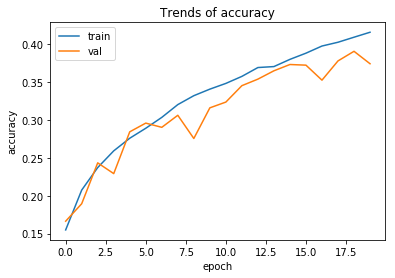

In [72]:
# X_train, X_test, Y_train, Y_test = np.load('./img_data.npy')

history = (model.fit(X_train, Y_train, validation_split=0.2,  batch_size=350, nb_epoch=20))
scores = model.evaluate(X_test, Y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
cvscores.append(scores[1] * 100)

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Trends of accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [287]:
diff = testresult.flatten() - testYdata.flatten()
absPercentDiff = np.abs(diff)
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))

[INFO] mean: 1.88%, std: 2.04%


In [115]:
print(np.sum(trainy[0]))
print(np.sum(trainy[0])/len(trainy[0]))

104952
4.270855375600228


In [23]:
model.save('Classification_foot_9class.h5')

In [9]:
# define two sets of inputs
inputA = Input(shape=(14,))
inputB = Input(shape=(32,32,3))
 
# the first branch operates on the first input
x = Dense(14, input_dim=14, activation="relu", kernel_initializer="normal")(inputA)
x = Dense(128, activation="relu", kernel_initializer="normal")(x)
x = Dense(128, activation="relu", kernel_initializer="normal")(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = Dense(9, activation="softmax", kernel_initializer="normal")(x)
x = Model(inputs = inputA, outputs = x)

# the second branch opreates on the second input

prior = keras.applications.VGG16( include_top=False,  weights='imagenet')(inputB)
y = Flatten()(prior)
y = Dense(512, activation='relu', name='Dense_Intermediate')(y)
y = (BatchNormalization())(y)
y = Dropout(0.5, name='Dropout_Regularization')(y)
y = Dense(9, activation='softmax', name='Output')(y)
y = Model(inputs = inputB, outputs = y)

In [11]:
# combine the output of the two branches
combined = concatenate([x.output, y.output], axis = 1)
 
# apply a FC layer and then a regression prediction on the
# combined outputs
z = Dense(64 ,activation="tanh")(combined)
z = Dense(16 ,activation="relu")(z)
z = (Dropout(0.3))(z)
z = (BatchNormalization())(z)
z = Dense(9, activation="softmax")(z)

# our model will accept the inputs of the two branches and
# then output a single value
M = Model(inputs=[x.input, y.input], outputs=z)

M.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adamax(lr=0.001), metrics=['accuracy'])
M.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 14)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 14)           210         input_1[0][0]                    
__________________________________________________________________________________________________
vgg16 (Model)                   multiple             14714688    input_2[0][0]                    
____________________________________________________________________________________________

In [12]:
# X_train, X_test, Y_train, Y_test = np.load('./img_data.npy')

skfolds=StratifiedKFold(n_splits=5, random_state=42,shuffle =True)
kfolds = KFold(n_splits=5,shuffle =True)

Y_train_recovery = np.argmax(Y_train, axis=1)
Mcvscores = []
M_history = []
start_time = time.time()


for train_index, valid_index in skfolds.split(X_train, Y_train_recovery):
    
    X_train_fold,X_valid_fold = X_train[train_index],X_train[valid_index]
    x_train_fold,x_valid_fold = x_train[train_index],x_train[valid_index]
    y_train_fold,y_valid_fold = Y_train[train_index],Y_train[valid_index]
 
#     NB_CLASSES = int(max(y)+1)
#     y_train_fold = np_utils.to_categorical(y, NB_CLASSES)
#     y_test_fold = np_utils.to_categorical(y, NB_CLASSES)
    M_history.append(M.fit([x_train_fold,X_train_fold],y_train_fold,validation_data = [[x_valid_fold,X_valid_fold],y_valid_fold], epochs=10, batch_size=2000,verbose=2))

    Mscores = M.evaluate([x_test,X_test],Y_test, verbose=0)
    print("%s: %.2f%%" % (M.metrics_names[1], Mscores[1]*100))
    Mcvscores.append(Mscores[1] * 100)

for i in range(len(M_history)):
    plt.plot(M_history[i].history['accuracy'])
    plt.plot(M_history[i].history['val_accuracy'])
#     plt.title('model accuracy')
    plt.ylabel('Accuracy',{'fontsize' : 20})
    plt.xlabel('Epoch',{'fontsize' : 20})
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

print("%.2f%% (+/- %.2f%%)" % (np.mean(Mcvscores), np.std(Mcvscores)))
print('run time :',round(time.time()-start_time,3)/60)

# M.save('M_Gersang.h5')

Train on 108633 samples, validate on 27162 samples
Epoch 1/10


ResourceExhaustedError:  OOM when allocating tensor with shape[2000,64,32,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradients/vgg16/block1_conv2/convolution_grad/Conv2DBackpropInput (defined at C:\ProgramData\Anaconda3\envs\tensorflow2.0\lib\site-packages\keras\backend\tensorflow_backend.py:3009) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_keras_scratch_graph_6576]

Function call stack:
keras_scratch_graph


In [ ]:
temp = []
trash = []

In [22]:
for i in range(5):
    for j in range(30):
        temp.append(M_history[i].history['accuracy'][j])
        trash.append(M_history[i].history['val_accuracy'][j])

In [ ]:
plt.plot(mt,label = 'train')
plt.plot(mtrash,label = 'test')
plt.title('Stacking Model')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')

In [21]:
M.save('Gersang.h5')
result = M.predict([x[0:100],X[0:100]])
print(pd.DataFrame((result)))
print(y[0:100])

           0         1         2         3         4         5         6  \
0   0.067659  0.279556  0.000220  0.052950  0.381929  0.000337  0.047289   
1   0.070776  0.275729  0.000222  0.055654  0.377894  0.000338  0.049751   
2   0.064646  0.283304  0.000217  0.050350  0.385819  0.000336  0.044925   
3   0.070776  0.275729  0.000222  0.055654  0.377894  0.000338  0.049751   
4   0.070776  0.275729  0.000222  0.055654  0.377894  0.000338  0.049751   
5   0.070776  0.275729  0.000222  0.055654  0.377894  0.000338  0.049751   
6   0.042284  0.312582  0.000195  0.031543  0.414767  0.000323  0.027921   
7   0.053768  0.297169  0.000207  0.041085  0.399894  0.000331  0.036527   
8   0.061772  0.286926  0.000215  0.047883  0.389525  0.000335  0.042685   
9   0.056356  0.293857  0.000210  0.043272  0.396512  0.000332  0.038505   
10  0.048893  0.303547  0.000202  0.037000  0.406243  0.000328  0.032838   
11  0.059007  0.290455  0.000212  0.045523  0.393085  0.000333  0.040543   
12  0.053768

In [70]:
M.fit([traindata,trainimgdata],trainy,validation_data=([testdata,testimgdata],testy),epochs=20,batch_size=100)
preds = model.predict([testdata,testimagedata])

NameError: name 'M' is not defined

In [89]:
np.mean(Ensemble_cvscores)

0.925450261808149

In [102]:
d

,0,1,2,3,4
0,0.909089,0.902786,0.909899,0.908367,0.913896
1,0.864042,0.864988,0.869077,0.872032,0.879971
2,0.816761,0.809392,0.834578,0.812729,0.817107
3,0.780677,0.816105,0.806436,0.816700,0.856703
4,0.930365,0.925529,0.926634,0.918831,0.925893


In [106]:
d = (KNN_cvscores,CART_cvscores,CNN_cvscores,RES_cvscores,Ensemble_cvscores)
d = pd.DataFrame(d)
d = d.transpose()
d.describe()

,0,1,2,3,4
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.908807,0.870022,0.818113,0.815324,0.925450
std,0.003988,0.006423,0.009733,0.027359,0.004170
min,0.902786,0.864042,0.809392,0.780677,0.918831
25%,0.908367,0.864988,0.812729,0.806436,0.925529
50%,0.909089,0.869077,0.816761,0.816105,0.925893
75%,0.909899,0.872032,0.817107,0.816700,0.926634
max,0.913896,0.879971,0.834578,0.856703,0.930365


In [94]:
d[0]

0    0.909089
1    0.864042
2    0.816761
3    0.780677
4    0.930365
Name: 0, dtype: float64

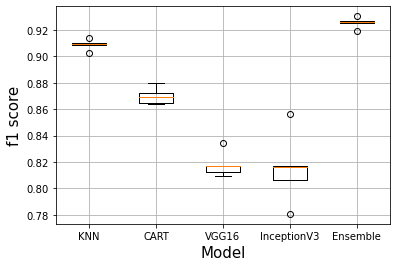

In [90]:
# plt.title('Accuracy comparison between models',{'fontsize' : 20})
plt.xlabel('Model',{'fontsize' : 15})
plt.ylabel('f1 score',{'fontsize' : 15})
plt.boxplot((KNN_cvscores,CART_cvscores,CNN_cvscores,RES_cvscores,Ensemble_cvscores),labels = ['KNN','CART','VGG16','InceptionV3','Ensemble'])
plt.grid()
# plt.legend(['MLP Model','CNN Model','Ensemble'])

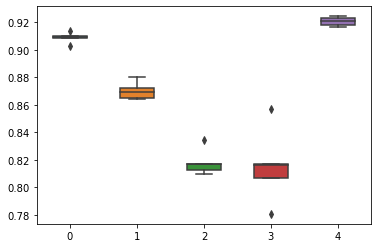

In [83]:
tip = [KNN_cvscores,CART_cvscores,CNN_cvscores,RES_cvscores,Ensemble_cvscores]
Model = ["K-NN","CART","VGG16","InceptionV3","Stacking Ensemble"]
sns.boxplot(width = 0.5,data=tip)